## Generate memory and cpu usage pattern from real jobs

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import tarfile
import json

%matplotlib inline

In [2]:
url = 'http://orange.com/employee/wgmn4901/data/'
data_dir = "../data/"

In [3]:
# list of current snapshot in data folder
!echo "Size\tName"
!ls -l $data_dir | grep "tar.gz" | awk '{print $5 "\t" $9}'

Size	Name
33820884	SnapshotOrangePortail_20160701.tar.gz


In [4]:
from shutil import copyfile
from six.moves.urllib.request import urlretrieve
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    if os.path.exists(data_dir+filename):
      #copy from data folder to working directory
      copyfile(data_dir+filename, filename)
    else:
      filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

#clustersnapshot = maybe_download('clustersnapshot24022016.tar.gz', 249468)
#clustersnapshot = maybe_download('clustersnapshot06042016.tar.gz', 1219174)
clustersnapshot = maybe_download('SnapshotOrangePortail_20160701.tar.gz', 33820884)

Found and verified SnapshotOrangePortail_20160701.tar.gz


In [5]:
def maybe_extract(filename,force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [ os.path.join(root, d) for d in sorted(os.listdir(root))
                if os.path.isdir(os.path.join(root, d))]
#  print('Found the following application profile in %s:' % filename)
#  for folder in data_folders:
#    print ('  %s' % folder)
  return data_folders
  
clustersnapshot_folders = maybe_extract(clustersnapshot)

SnapshotOrangePortail_20160701 already present - Skipping extraction of SnapshotOrangePortail_20160701.tar.gz.


In [6]:
import pandas as pd #this is how I usually import pandas

def load_application(folder):
  """Load the container data for each application."""
  container_index = 0
  container_name_list = []
  container_starttime_list = []
  container_endtime_list = []
  container_type_list = []
  container_task_list = []
  container_node_list = []
  container_node_mem_total_list = []
  container_node_CPU_total_list = []
  container_node_mem_rsrv_list = []
  container_node_CPU_rsrv_list = []
  container_mem_assigned_list = []
  container_CPU_assigned_list = []
  appId_list = [] #this one should be call appId
  appname_list = []
  appowner_list = []
  application_starttime = 100000000000000 # really big number
  application_endtime = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        container_starttime = data["container_starttime"]
        if container_starttime < application_starttime:
          application_starttime = container_starttime        
        container_endtime = data["container_endtime"]
        if container_endtime > application_endtime:
          application_endtime = container_endtime
        """gather info for container"""
        container_type = data["application_info"]["appType"] #First task only
        appId = data["application_info"]["appId"]
        appname = data["application_info"]["appName"]
        appowner = data["application_info"]["appOwner"]
        if not data["nodeInfo"]:
            container_node = "null"
            container_node_mem_total = 0
            container_node_CPU_total = 0
            container_node_mem_rsrv = 0
            container_node_CPU_rsrv = 0
            container_mem_assigned = 0
            container_CPU_assigned = 0
        else:
            container_node = data["nodeInfo"]["id"]
            container_node_mem_total = data["nodeInfo"]["totalNodePhyMem"]
            container_node_CPU_total = data["nodeInfo"]["totalNodePhyCore"]
            container_node_mem_rsrv = data["nodeInfo"]["totalPmemAllocatedContainersMB"] * 1024
            container_node_CPU_rsrv = data["nodeInfo"]["totalVCoresAllocatedContainers"]
            container_mem_assigned = data["MemoryAssignedMB"] * 1024
            container_CPU_assigned = data["VCoresAssigned"]
        if not data["container_tasks"]:
            container_task = "null"
        else:
            container_task = data["container_tasks"][0]["task_type"]
        """make list to create dataframe"""
        container_name_list.insert(container_index,container_name)
        container_starttime_list.insert(container_index,container_starttime)
        container_endtime_list.insert(container_index,container_endtime)
        container_type_list.insert(container_index,container_type)
        container_task_list.insert(container_index,container_task)
        container_node_list.insert(container_index,container_node)
        container_node_mem_total_list.insert(container_index,container_node_mem_total)
        container_node_CPU_total_list.insert(container_index,container_node_CPU_total)
        container_node_mem_rsrv_list.insert(container_index,container_node_mem_rsrv)
        container_node_CPU_rsrv_list.insert(container_index,container_node_CPU_rsrv)
        container_mem_assigned_list.insert(container_index,container_mem_assigned)
        container_CPU_assigned_list.insert(container_index,container_CPU_assigned)
        appId_list.insert(container_index,appId)
        appname_list.insert(container_index,appname)
        appowner_list.insert(container_index,appowner)
      #if not container_name:
      #  raise Exception('Unexpected container name')
      #if container_starttime == 0:
      #  raise Exception('Unexpected container start time')
      #if container_endtime == 0:
      #  raise Exception('Unexpected container end time')
      container_index += 1
    except IOError as e:
      print('Could not read:', container_file, ':', e)
    except ValueError as e:
      print('Wrong format. Could not read:', container_file, ':', e)
  DataSet = list(zip(container_starttime_list,container_endtime_list,
                     container_type_list,container_task_list,container_node_list,container_node_mem_total_list,
                     container_node_CPU_total_list,container_node_mem_rsrv_list,container_node_CPU_rsrv_list,
                     container_mem_assigned_list, container_CPU_assigned_list, appId_list, appname_list, appowner_list))
  columns=[ 'start', 'end', 'type', 'task', 'node','n_mem','n_CPU',
                                    'mem_rsrv','CPU_rsrv','mem','CPU','app','appname', 'appowner']
  DataFrame = pd.DataFrame(data = DataSet, index=container_name_list,
                           columns=columns)
  return DataFrame, application_starttime, application_endtime

def load_snapshot(snapshot_folders):
  snapshot_starttime = 100000000000000 # really big number
  snapshot_endtime = 0
  snapshot_dataframe = pd.DataFrame()
  for application_folder in snapshot_folders: 
    dataframe, application_starttime, application_endtime = load_application(application_folder)
    if application_starttime < snapshot_starttime:
      snapshot_starttime = application_starttime
    if application_endtime > snapshot_endtime:
      snapshot_endtime = application_endtime
    if snapshot_dataframe.empty:
      snapshot_dataframe = dataframe
    else:
      snapshot_dataframe = snapshot_dataframe.append(dataframe)
  return snapshot_dataframe, snapshot_starttime, snapshot_endtime

snapshot_dataframe,snapshot_starttime,snapshot_endtime = load_snapshot(clustersnapshot_folders)
print('Snapshot start time: %s' % snapshot_starttime)
print('Snapshot end time: %s' % snapshot_endtime)
snapshot_duration = snapshot_endtime-snapshot_starttime
print('Snapshot duration: %s ms (or ~%s s or ~%s m)' % (snapshot_duration,snapshot_duration/1000,snapshot_duration/60000))
snapshot_dataframe.head(n=5)

Snapshot start time: 1467329762269
Snapshot end time: 1467410265091
Snapshot duration: 80502822 ms (or ~80502 s or ~1341 m)


start            end  \
container_e88_1467203595416_1981_01_000001  1467329762269  1467329815856   
container_e88_1467203595416_1981_01_000002  1467329769273  1467329809851   
container_e88_1467203595416_1982_01_000005  1467329787743  1467329803095   
container_e88_1467203595416_1982_01_000009  1467329788287  1467329801921   
container_e88_1467203595416_1982_01_000025  1467329790982  1467329801931   

                                                 type task  \
container_e88_1467203595416_1981_01_000001  MAPREDUCE   AM   
container_e88_1467203595416_1981_01_000002  MAPREDUCE  MAP   
container_e88_1467203595416_1982_01_000005  MAPREDUCE  MAP   
container_e88_1467203595416_1982_01_000009  MAPREDUCE  MAP   
container_e88_1467203595416_1982_01_000025  MAPREDUCE  MAP   

                                                                                         node  \
container_e88_1467203595416_1981_01_000001  datanode004.current.rec.mapreduce.m1.p.fti.net...   
container_e88_1467203595416_1981_01_000002  datanode004.current.rec.mapreduce.m1.p.fti.net...   
container_e88_1467203595416_1982_01_000005  datanode005.current.rec.mapreduce.m1.p.fti.net...   
container_e88_1467203595416_1982_01_000009  datanode004.current.rec.mapreduce.m1.p.fti.net...   
container_e88_1467203595416_1982_01_000025  datanode006.current.rec.mapreduce.m1.p.fti.net...   

                                               n_mem  n_CPU  mem_rsrv  \
container_e88_1467203595416_1981_01_000001  66058808     24  56623104   
container_e88_1467203595416_1981_01_000002  66058808     24  56623104   
container_e88_1467203595416_1982_01_000005  66058808     24  56623104   
container_e88_1467203595416_1982_01_000009  66058808     24  56623104   
container_e88_1467203595416_1982_01_000025  66058808     24  56623104   

                                            CPU_rsrv      mem  CPU  \
container_e88_1467203595416_1981_01_000001        24  2097152    1   
container_e88_1467203595416_1981_01_000002        24  2097152    1   
container_e88_1467203595416_1982_01_000005        24  2097152    1   
container_e88_1467203595416_1982_01_000009        24  2097152    1   
container_e88_1467203595416_1982_01_000025        24  2097152    1   

                                                                       app  \
container_e88_1467203595416_1981_01_000001  application_1467203595416_1981   
container_e88_1467203595416_1981_01_000002  application_1467203595416_1981   
container_e88_1467203595416_1982_01_000005  application_1467203595416_1982   
container_e88_1467203595416_1982_01_000009  application_1467203595416_1982   
container_e88_1467203595416_1982_01_000025  application_1467203595416_1982   

                                                                                      appname  \
container_e88_1467203595416_1981_01_000001  oozie:launcher:T=java:W=astrolog-1.8-SNAPSHOT:...   
container_e88_1467203595416_1981_01_000002  oozie:launcher:T=java:W=astrolog-1.8-SNAPSHOT:...   
container_e88_1467203595416_1982_01_000005                           Astrolog::ASTROPOLIS_PNS   
container_e88_1467203595416_1982_01_000009                           Astrolog::ASTROPOLIS_PNS   
container_e88_1467203595416_1982_01_000025                           Astrolog::ASTROPOLIS_PNS   

                                            appowner  
container_e88_1467203595416_1981_01_000001  astrolog  
container_e88_1467203595416_1981_01_000002  astrolog  
container_e88_1467203595416_1982_01_000005  astrolog  
container_e88_1467203595416_1982_01_000009  astrolog  
container_e88_1467203595416_1982_01_000025  astrolog

In [7]:
# Load data into notebook
snapshot_dataframe,snapshot_starttime,snapshot_endtime = load_snapshot(clustersnapshot_folders)
print('Snapshot start time: %s' % snapshot_starttime)
print('Snapshot end time: %s' % snapshot_endtime)
snapshot_duration = snapshot_endtime-snapshot_starttime
print('Snapshot duration: %s ms (or ~%s s or ~%s m)' % (snapshot_duration,snapshot_duration/1000,snapshot_duration/60000))

Snapshot start time: 1467329762269
Snapshot end time: 1467410265091
Snapshot duration: 80502822 ms (or ~80502 s or ~1341 m)


In [8]:
# Sort by start time
SnapshotDFSorted = snapshot_dataframe.sort_values(by="start")
# Filter
SnapshotDFFiltered = SnapshotDFSorted[(SnapshotDFSorted.node != 'null')]
SnapshotDFFiltered = SnapshotDFSorted[(SnapshotDFSorted.end > 0)]
SnapshotDFFiltered.head(n=5)

start            end  \
container_e88_1467203595416_1981_01_000001  1467329762269  1467329815856   
container_e88_1467203595416_1981_01_000002  1467329769273  1467329809851   
container_e88_1467203595416_1982_01_000001  1467329779973  1467329811601   
container_e88_1467203595416_1982_01_000002  1467329787220  1467329802464   
container_e88_1467203595416_1982_01_000003  1467329787286  1467329800059   

                                                 type task  \
container_e88_1467203595416_1981_01_000001  MAPREDUCE   AM   
container_e88_1467203595416_1981_01_000002  MAPREDUCE  MAP   
container_e88_1467203595416_1982_01_000001  MAPREDUCE   AM   
container_e88_1467203595416_1982_01_000002  MAPREDUCE  MAP   
container_e88_1467203595416_1982_01_000003  MAPREDUCE  MAP   

                                                                                         node  \
container_e88_1467203595416_1981_01_000001  datanode004.current.rec.mapreduce.m1.p.fti.net...   
container_e88_1467203595416_1981_01_000002  datanode004.current.rec.mapreduce.m1.p.fti.net...   
container_e88_1467203595416_1982_01_000001  datanode006.current.rec.mapreduce.m1.p.fti.net...   
container_e88_1467203595416_1982_01_000002  datanode002.current.rec.mapreduce.m1.p.fti.net...   
container_e88_1467203595416_1982_01_000003  datanode004.current.rec.mapreduce.m1.p.fti.net...   

                                               n_mem  n_CPU  mem_rsrv  \
container_e88_1467203595416_1981_01_000001  66058808     24  56623104   
container_e88_1467203595416_1981_01_000002  66058808     24  56623104   
container_e88_1467203595416_1982_01_000001  66058808     24  56623104   
container_e88_1467203595416_1982_01_000002  66058808     24  56623104   
container_e88_1467203595416_1982_01_000003  66058808     24  56623104   

                                            CPU_rsrv      mem  CPU  \
container_e88_1467203595416_1981_01_000001        24  2097152    1   
container_e88_1467203595416_1981_01_000002        24  2097152    1   
container_e88_1467203595416_1982_01_000001        24  2097152    1   
container_e88_1467203595416_1982_01_000002        24  2097152    1   
container_e88_1467203595416_1982_01_000003        24  2097152    1   

                                                                       app  \
container_e88_1467203595416_1981_01_000001  application_1467203595416_1981   
container_e88_1467203595416_1981_01_000002  application_1467203595416_1981   
container_e88_1467203595416_1982_01_000001  application_1467203595416_1982   
container_e88_1467203595416_1982_01_000002  application_1467203595416_1982   
container_e88_1467203595416_1982_01_000003  application_1467203595416_1982   

                                                                                      appname  \
container_e88_1467203595416_1981_01_000001  oozie:launcher:T=java:W=astrolog-1.8-SNAPSHOT:...   
container_e88_1467203595416_1981_01_000002  oozie:launcher:T=java:W=astrolog-1.8-SNAPSHOT:...   
container_e88_1467203595416_1982_01_000001                           Astrolog::ASTROPOLIS_PNS   
container_e88_1467203595416_1982_01_000002                           Astrolog::ASTROPOLIS_PNS   
container_e88_1467203595416_1982_01_000003                           Astrolog::ASTROPOLIS_PNS   

                                            appowner  
container_e88_1467203595416_1981_01_000001  astrolog  
container_e88_1467203595416_1981_01_000002  astrolog  
container_e88_1467203595416_1982_01_000001  astrolog  
container_e88_1467203595416_1982_01_000002  astrolog  
container_e88_1467203595416_1982_01_000003  astrolog

In [9]:
def load_application_cpu_profile(folder):
  """Load the container data for each application."""
  record_index_list = []
  container_name_list = []
  capture_time_list = []
  container_load_list = []
  cpu_us_list = []
  cpu_sys_list = []
  cpu_id_list = []
  fail_count = 0
  record_index = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        if not data["cpu_usage"]:
          #print('No infomation for container %s, ignore it' % container_name)
          fail_count = fail_count + 1
        else:
          for record in data["cpu_usage"]:
            container_capture_time = record["capture_time"]
            container_load = record["container_load"] / 100
            cpu_us = record["cpu_us"]
            cpu_sys = record["cpu_sy"]
            cpu_id = record["cpu_id"]
            '''make list to create dataframe'''
            record_index_list.insert(record_index,record_index)
            container_name_list.insert(record_index,container_name)
            capture_time_list.insert(record_index,container_capture_time)
            container_load_list.insert(record_index,container_load)
            cpu_us_list.insert(record_index,cpu_us)
            cpu_sys_list.insert(record_index,cpu_sys)
            cpu_id_list.insert(record_index,cpu_id)
            record_index += 1
      if not container_name:
        raise Exception('Unexpected container name')
    except IOError as e:
      print('Could not read:', container_file, ':', e)
    except ValueError as e:
      print('Wrong format. Could not read:', container_file, ':', e)
  DataSet = list(zip(capture_time_list,container_name_list,container_load_list,cpu_us_list,cpu_sys_list,cpu_id_list))
  columns=[ 'timestamp','name','cpu_load', 'cpu_us', 'cpu_sys', 'cpu_id']
  DataFrame = pd.DataFrame(data = DataSet, index=record_index_list,columns=columns)
  return DataFrame, fail_count

def load_snapshot_cpu_profile(snapshot_folder):
  snapshot_dataframe = pd.DataFrame()
  snapshot_failcount = 0
  for application_folder in snapshot_folder:
    dataframe, fail_count = load_application_cpu_profile(application_folder)
    if snapshot_dataframe.empty:
      snapshot_dataframe = dataframe
    else:
      snapshot_dataframe = snapshot_dataframe.append(dataframe)
    snapshot_failcount = snapshot_failcount + fail_count
  return snapshot_dataframe, snapshot_failcount

snapshot_cpu_profile, snapshot_failcount = load_snapshot_cpu_profile(clustersnapshot_folders)
print ("Done! Loading %d profiles of %d containers, fail %d containers with no information" % 
       (len(snapshot_cpu_profile.name.unique()),
        len(snapshot_cpu_profile.name.unique()) + snapshot_failcount,
        snapshot_failcount))
snapshot_cpu_profile.head(n=5)

Done! Loading 17395 profiles of 19832 containers, fail 2437 containers with no information


timestamp                                        name  cpu_load  cpu_us  \
0  1.467330e+09  container_e88_1467203595416_1981_01_000001     2.636    21.2   
1  1.467330e+09  container_e88_1467203595416_1981_01_000001     2.356     9.5   
2  1.467330e+09  container_e88_1467203595416_1981_01_000001     2.515    10.8   
3  1.467330e+09  container_e88_1467203595416_1981_01_000001     4.203    16.8   
4  1.467330e+09  container_e88_1467203595416_1981_01_000001     4.472    18.4   

   cpu_sys  cpu_id  
0      2.1    76.4  
1      1.0    89.4  
2      1.1    87.8  
3      0.7    82.4  
4      0.5    81.1

In [10]:
def get_cpu_actual_use(container_name, snapshot_dataframe, snapshot_cpu_profile):
  container_starttime = snapshot_dataframe.loc[container_name,'start']
  container_endtime = snapshot_dataframe.loc[container_name,'end']
  rescaled_container_starttime = container_starttime / 1000
  rescaled_container_endtime = container_endtime / 1000
  duration = rescaled_container_endtime - rescaled_container_starttime
  container_index = np.linspace(rescaled_container_starttime, rescaled_container_endtime -1,duration)
  data = np.linspace(0,0,duration)
  container_data2 = pd.Series(data,index=pd.to_datetime(container_index,unit='s'))

  cpu_container_filtered = snapshot_cpu_profile[(snapshot_cpu_profile.name == container_name)]
  index = cpu_container_filtered.timestamp.tolist()
  cpu_load = cpu_container_filtered.cpu_load.tolist()
  container_data1 = pd.Series(cpu_load,index=pd.to_datetime(index,unit='s'))
  container_data3 = container_data1 + container_data2
  container_data4 = container_data3.interpolate(method='time')
  for index in container_data4.index:
    if pd.isnull(container_data4[index]):
      container_data4[index] = container_data4.mean()
  if len(container_data4) > len(container_data2):
    a = set(container_data4.index.tolist()) - set(container_data2.index.tolist())
    #print(a) # to see match data point
    #raise Exception('Return length mismatch')
    
  return container_data4

In [11]:
import matplotlib.pyplot as plt
import matplotlib #only needed to determine Matplotlib version number
from random import randint
import pylab

# Enable inline plotting
%matplotlib inline
pylab.rcParams['figure.figsize'] = (15.0, 8.0)

ValueError: Number of samples, -1467624012, must be non-negative.

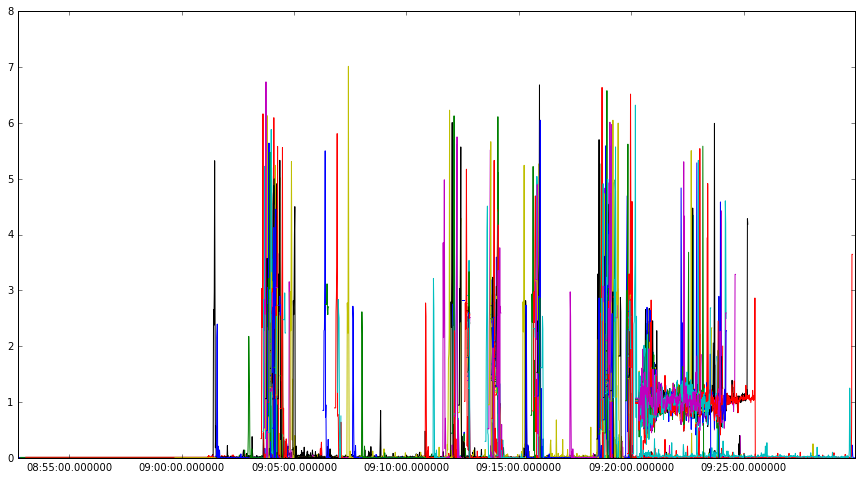

In [17]:
for i in SnapshotDFFiltered.index:
  a = get_cpu_actual_use(i,snapshot_dataframe, snapshot_cpu_profile)
  plt.plot(a)

In [12]:
def load_application_mem_profile(folder):
  """Load the container data for each application."""
  record_index_list = []
  container_name_list = []
  capture_time_list = []
  container_mem_virt_list = []
  container_mem_res_list = []
  container_mem_shr_list = []
  used_pmem_list = [] #system info
  swap_cached_list = [] # system info
  fail_count = 0
  record_index = 0
  for container in os.listdir(folder):
    container_file = os.path.join(folder, container)
    try:
      with open(container_file) as data_file:    
        data = json.load(data_file)
        container_name = data["container_id"]
        if not data["memory_usage"]:
          #print('No infomation for container %s, ignore it' % container_name)
          fail_count = fail_count + 1
        else:
          for record in data["memory_usage"]:
            container_capture_time = record["capture_time"]
            container_mem_virt = record["virt"]
            container_mem_res = record["res"]
            container_mem_shr = record["shr"]
            used_pmem = record["used_pmem"]
            swap_cached = record["swap_cached"]
            '''make list to create dataframe'''
            record_index_list.insert(record_index,record_index)
            container_name_list.insert(record_index,container_name)
            capture_time_list.insert(record_index,container_capture_time)
            container_mem_virt_list.insert(record_index,container_mem_virt)
            container_mem_res_list.insert(record_index,container_mem_res)
            container_mem_shr_list.insert(record_index,container_mem_shr)
            used_pmem_list.insert(record_index,used_pmem)
            swap_cached_list.insert(record_index,swap_cached)
            record_index += 1
      if not container_name:
        raise Exception('Unexpected container name')
    except IOError as e:
      print('Could not read:', container_file, ':', e)
    except ValueError as e:
      print('Wrong format. Could not read:', container_file, ':', e)
  DataSet = list(zip(capture_time_list,container_name_list,container_mem_virt_list,
                     container_mem_res_list,container_mem_shr_list,used_pmem_list,swap_cached_list))
  columns=[ 'timestamp','name','virt', 'res', 'shr', 'used_pmem','swap_cached']
  DataFrame = pd.DataFrame(data = DataSet, index=record_index_list,columns=columns)
  return DataFrame, fail_count

def load_snapshot_mem_profile(snapshot_folder):
  snapshot_dataframe = pd.DataFrame()
  snapshot_failcount = 0
  for application_folder in snapshot_folder:
    dataframe, fail_count = load_application_mem_profile(application_folder)
    if snapshot_dataframe.empty:
      snapshot_dataframe = dataframe
    else:
      snapshot_dataframe = snapshot_dataframe.append(dataframe)
    snapshot_failcount = snapshot_failcount + fail_count
  return snapshot_dataframe, snapshot_failcount

snapshot_mem_profile, snapshot_failcount = load_snapshot_mem_profile(clustersnapshot_folders)
print ("Done! Loading %d profiles of %d containers, fail %d containers with no information" % 
       (len(snapshot_mem_profile.name.unique()),
        len(snapshot_mem_profile.name.unique()) + snapshot_failcount,
        snapshot_failcount))
snapshot_mem_profile.head(n=5)

Done! Loading 17395 profiles of 19832 containers, fail 2437 containers with no information


timestamp                                        name          virt  \
0  1.467330e+09  container_e88_1467203595416_1981_01_000001  3.587178e+09   
1  1.467330e+09  container_e88_1467203595416_1981_01_000001  3.632267e+09   
2  1.467330e+09  container_e88_1467203595416_1981_01_000001  3.654287e+09   
3  1.467330e+09  container_e88_1467203595416_1981_01_000001  3.674210e+09   
4  1.467330e+09  container_e88_1467203595416_1981_01_000001  3.730833e+09   

           res         shr     used_pmem   swap_cached  
0  108003328.0  25165824.0  1.826051e+10  8.466231e+09  
1  267386880.0  26214400.0  1.811551e+10  8.471163e+09  
2  375390208.0  26214400.0  1.821692e+10  8.466014e+09  
3  482344960.0  27262976.0  1.832786e+10  8.472482e+09  
4  517996544.0  27262976.0  1.836064e+10  8.467354e+09

In [13]:
def get_mem_actual_use(container_name, snapshot_dataframe, snapshot_mem_profile):
  container_starttime = snapshot_dataframe.loc[container_name,'start']
  container_endtime = snapshot_dataframe.loc[container_name,'end']
  rescaled_container_starttime = container_starttime / 1000
  rescaled_container_endtime = container_endtime / 1000
  duration = rescaled_container_endtime - rescaled_container_starttime
  container_index = np.linspace(rescaled_container_starttime, rescaled_container_endtime -1,duration)
  data = np.linspace(0,0,duration)
  container_data2 = pd.Series(data,index=pd.to_datetime(container_index,unit='s'))

  mem_container_filtered = snapshot_mem_profile[(snapshot_mem_profile.name == container_name)]
  index = mem_container_filtered.timestamp.tolist()
  # get resident memory
  mem = mem_container_filtered.res.tolist()
  # get share memory
  #mem = mem_container_filtered.shr.tolist()
  # get virt memory
  #mem = mem_container_filtered.virt.tolist()
  container_data1 = pd.Series(mem,index=pd.to_datetime(index,unit='s'))
  container_data3 = container_data1 + container_data2
  container_data4 = container_data3.interpolate(method='time')
  for index in container_data4.index:
    if pd.isnull(container_data4[index]):
      container_data4[index] = container_data4.mean()
  if len(container_data4) > len(container_data2):
    a = set(container_data4.index.tolist()) - set(container_data2.index.tolist())
    #print(a) # to see mismatch data point
    #raise Exception('Return length mismatch')
    
  return container_data4

In [ ]:
for container in SnapshotDFFiltered.index:
  mem_used = get_mem_actual_use(container,snapshot_dataframe, snapshot_mem_profile)
  mem_used = [ x / (1024*1024*1024) for x in mem_used ]
  plt.plot(mem_used)

## Normalize Memory and CPU Usage Pattern

In [ ]:
for container in SnapshotDFFiltered.index:
  cpu_usage = get_cpu_actual_use(container,snapshot_dataframe, snapshot_cpu_profile)
  cpu_usage = [ x /snapshot_dataframe.loc[container,"CPU"] for x in cpu_usage ] # normalize with reserved CPU
  plt.plot(cpu_usage)

In [ ]:
for container in SnapshotDFFiltered.index:
  mem_used = get_mem_actual_use(container,snapshot_dataframe, snapshot_mem_profile)
  mem_used = [ x / (snapshot_dataframe.loc[container,"mem"]*1024) for x in mem_used ] # normalize with reserved mem
  plt.plot(mem_used)

## Build container list to run in simulator from real workload

In [454]:
DataSet = list(zip(SnapshotDFFiltered.app, SnapshotDFFiltered.task, SnapshotDFFiltered.start,
                   SnapshotDFFiltered.end, SnapshotDFFiltered.end - SnapshotDFFiltered.start,
                   SnapshotDFFiltered.mem, SnapshotDFFiltered.CPU, SnapshotDFFiltered.node))
columns=[ 'app_id','task', 'start', 'end', 'duration','mem','CPU','node']
ContainerDF = pd.DataFrame(data = DataSet, index=SnapshotDFFiltered.index,columns=columns)

In [455]:
#ContainerDF = ContainerDF[(ContainerDF.node != 'svr05.spo:45454')]
ContainerDF = ContainerDF[(ContainerDF.node != 'null')]
#ContainerDF = ContainerDF[(ContainerDF.app_id == 'application_1458297422021_0016')]
ContainerDF.head(n=10)

app_id  \
container_e88_1467203595416_1981_01_000001  application_1467203595416_1981   
container_e88_1467203595416_1981_01_000002  application_1467203595416_1981   
container_e88_1467203595416_1982_01_000001  application_1467203595416_1982   
container_e88_1467203595416_1982_01_000002  application_1467203595416_1982   
container_e88_1467203595416_1982_01_000003  application_1467203595416_1982   
container_e88_1467203595416_1982_01_000004  application_1467203595416_1982   
container_e88_1467203595416_1982_01_000005  application_1467203595416_1982   
container_e88_1467203595416_1982_01_000006  application_1467203595416_1982   
container_e88_1467203595416_1982_01_000007  application_1467203595416_1982   
container_e88_1467203595416_1982_01_000008  application_1467203595416_1982   

                                           task          start            end  \
container_e88_1467203595416_1981_01_000001   AM  1467329762269  1467329815856   
container_e88_1467203595416_1981_01_000002  MAP  1467329769273  1467329809851   
container_e88_1467203595416_1982_01_000001   AM  1467329779973  1467329811601   
container_e88_1467203595416_1982_01_000002  MAP  1467329787220  1467329802464   
container_e88_1467203595416_1982_01_000003  MAP  1467329787286  1467329800059   
container_e88_1467203595416_1982_01_000004  MAP  1467329787712  1467329802551   
container_e88_1467203595416_1982_01_000005  MAP  1467329787743  1467329803095   
container_e88_1467203595416_1982_01_000006  MAP  1467329787979  1467329802038   
container_e88_1467203595416_1982_01_000007  MAP  1467329787980  1467329803013   
container_e88_1467203595416_1982_01_000008  MAP  1467329788220  1467329800418   

                                            duration      mem  CPU  \
container_e88_1467203595416_1981_01_000001     53587  2097152    1   
container_e88_1467203595416_1981_01_000002     40578  2097152    1   
container_e88_1467203595416_1982_01_000001     31628  2097152    1   
container_e88_1467203595416_1982_01_000002     15244  2097152    1   
container_e88_1467203595416_1982_01_000003     12773  2097152    1   
container_e88_1467203595416_1982_01_000004     14839  2097152    1   
container_e88_1467203595416_1982_01_000005     15352  2097152    1   
container_e88_1467203595416_1982_01_000006     14059  2097152    1   
container_e88_1467203595416_1982_01_000007     15033  2097152    1   
container_e88_1467203595416_1982_01_000008     12198  2097152    1   

                                                                                         node  
container_e88_1467203595416_1981_01_000001  datanode004.current.rec.mapreduce.m1.p.fti.net...  
container_e88_1467203595416_1981_01_000002  datanode004.current.rec.mapreduce.m1.p.fti.net...  
container_e88_1467203595416_1982_01_000001  datanode006.current.rec.mapreduce.m1.p.fti.net...  
container_e88_1467203595416_1982_01_000002  datanode002.current.rec.mapreduce.m1.p.fti.net...  
container_e88_1467203595416_1982_01_000003  datanode004.current.rec.mapreduce.m1.p.fti.net...  
container_e88_1467203595416_1982_01_000004  datanode001.current.rec.mapreduce.m1.p.fti.net...  
container_e88_1467203595416_1982_01_000005  datanode005.current.rec.mapreduce.m1.p.fti.net...  
container_e88_1467203595416_1982_01_000006  datanode006.current.rec.mapreduce.m1.p.fti.net...  
container_e88_1467203595416_1982_01_000007  datanode003.current.rec.mapreduce.m1.p.fti.net...  
container_e88_1467203595416_1982_01_000008  datanode002.current.rec.mapreduce.m1.p.fti.net...

In [1001]:
ContainerDF.groupby(by='task').count()
# None = schedule on RM but not run, like speculative task
# null = other application, not MapReduce

app_id  start    end  duration    mem    CPU   node
task                                                       
AM        1549   1549   1549      1549   1549   1549   1549
MAP      14220  14220  14220     14220  14220  14220  14220
None      1889   1889   1889      1889   1889   1889   1889
REDUCE     958    958    958       958    958    958    958
null      1111   1111   1111      1111   1111   1111   1111

In [1010]:
ContainerDF[(ContainerDF.task == 'None')].duration.max()

7957

## Simulation program

In [1170]:
def adding_array(list_a, list_b, starting_index = 0 ):
    list_b_len = len(list_b)
    list_b_index = 0
    while list_b_index < list_b_len:
        if starting_index < len(list_a):
            list_a[starting_index] = list_a[starting_index] + list_b[list_b_index]
            list_b_index += 1
            starting_index += 1
        else:
            break
    return list_a
# Test function
list_a = [1, 2, 3, 4, 5, 6]
list_b = [2, 6]
list_a = adding_array(list_a, list_b)
print(list_a)

[3, 8, 3, 4, 5, 6]


In [1171]:
import math
class container:
    'Common base class for all containers'
    conCount = 0
    
    def __init__(self, con_id, app_id, resv_memory, resv_CPU, duration, con_type = 'null'):
        self.con_id = con_id
        self.app_id = app_id
        self.con_type = con_type
        self.resv_memory = resv_memory #MB
        self.resv_CPU = resv_CPU       #number of cores
        self.duration = duration       #milisecond
        
        self.mem_used = []
        self.cpu_used = []
        self.mem_estimated = []
        self.cpu_estimated = []
        self.UsageInfoAvailable = False
        self.EstimationInfoAvailable = False
        
        container.conCount += 1
        
    def _loadMemUsed(self, containerDF, mem_profileDF, debug = False):
        mem_used = get_mem_actual_use(self.con_id, containerDF, mem_profileDF)
        self.mem_used = [ x/(1024*1024) for x in mem_used] #MB
        
        NaN_exist = False
        for i in self.mem_used:
            if math.isnan(i):
                if debug == True:
                    print(self.mem_used)
                NaN_exist = True
                break
                
        if self.mem_used:
            if not NaN_exist:
                return True
        else:
            self.mem_used = []
            return False
        
    def _loadCPUUsed(self, containerDF, cpu_profileDF, debug = False):
        cpu_used = get_cpu_actual_use(self.con_id, containerDF, cpu_profileDF)
        self.cpu_used = [ x for x in cpu_used ]
        
        NaN_exist = False
        for i in self.mem_used:
            if math.isnan(i):
                if debug == True:
                    print(self.mem_used)
                NaN_exist = True
                break
                
        if self.cpu_used:
            if not NaN_exist:
                return True
        else:
            self.cpu_used = []
            return False
        
    def _doMemEstimation(self, alpha=0.0):
        duration = len(self.mem_used)
        if duration > 0:
            self.mem_estimated = [0]*duration 
            self.mem_estimated[0] = self.resv_memory       
            for time_t in range(duration - 1 ):
                if self.mem_used[time_t+1] > self.mem_estimated[time_t]:
                    self.mem_estimated[time_t + 1] = self.mem_used[time_t+1]
                else:
                    self.mem_estimated[time_t + 1] = self.mem_estimated[time_t]*(1 - alpha) + self.mem_used[time_t+1]*alpha
            return True
        else:
            return False
        
    def _doCPUEstimation(self, alpha=0.0):
        duration = len(self.cpu_used)
        if duration > 0:
            self.cpu_estimated = [0]*duration
            self.cpu_estimated[0] = self.resv_CPU
        
            for time_t in range(duration - 1 ):
                if self.cpu_used[time_t+1] > self.cpu_estimated[time_t]:
                    self.cpu_estimated[time_t + 1] = self.cpu_used[time_t+1]
                else:
                    self.cpu_estimated[time_t + 1] = self.cpu_estimated[time_t]*(1 - alpha) + self.cpu_used[time_t+1]*alpha
            return True
        else:
            return False
    
    def loadResourceUsedInfo(self, containerDF, mem_profileDF, cpu_profileDF): 
        MemUsedAvai = self._loadMemUsed(containerDF, mem_profileDF)
        CPUUsedAvai = self._loadCPUUsed(containerDF, cpu_profileDF)
        if MemUsedAvai and CPUUsedAvai:
            self.UsedInfoAvailable = True
            return True
        else:
            self.mem_used = []
            self.cpu_used = []
            return False
        
    def doEstimation(self, alpha = 0.125):
        MemEstAvai = self._doMemEstimation(alpha)
        CPUEstAvai = self._doCPUEstimation(alpha)
        if MemEstAvai and CPUEstAvai:
            self.EstimationInfoAvailable = True
            return True
        else:
            self.mem_estimated = []
            self.cpu_estimated = []
            return False
    
    def findMaxMemUsed(self):
        return max(self.mem_used)
    
    def findMaxCpuUsed(self):
        return max(self.cpu_used)
    
    def setPerfectMemReservation(self, safety_margin = 0):
        self.resv_memory = self.findMaxMemUsed() + safety_margin
    
    def __del__( self ):
        container.conCount -= 1
        
    def displayCount(self):
        print ("Total container: %d" % container.conCount)
    
    def displayContainer(self):
        print ("Container ID: %s" % self.con_id)
        print ("Application ID: %s" % self.app_id)
        print ("Container reserved memory (MBs): %d" % self.resv_memory)
        print ("Container reserved CPU (core): %d" % self.resv_CPU)
        print ("Container duration (second): %d" % self.duration)
    
    def getActualMemoryUsage(self):
        return 0
    
    def getActualMemoryUsage(self):
        return 0
        

In [1172]:
class container_queue:
    
    def __init__(self):
        self.queue = []
        self.arrivetime = []
        
    def __call__(self):
        self.queue = []
        self.arrivetime = []
    
    def addToQueue(self, container, attime):
        self.queue.append(container)
        self.arrivetime.append(attime)
    
    def empty(self):
        if len(self.queue) == 0:
            return True
        else:
            return False
    
    def getFirstContainer(self):
        if not self.queue:
            raise Exception('Queue is empty')
        else:
            return self.queue[0], self.arrivetime[0]
    
    def popAtFirstPosition(self):
        if not self.queue:
            raise Exception('Queue is empty')
        else:       
            container = self.queue[0]
            self.queue.pop(0)
            self.arrivetime.pop(0)
            return container
    
    def popAtLastPosition(self):
        if not self.queue:
            raise Exception('Queue is empty')
        else:
            container = self.queue[len(self.queue)-1]
            self.queue.pop()
            self.arrivetime.pop()
            return container            
    
    def generateContainerQueue(self, containerDF, MemProfileDF, CPUProfileDF, perfect_resv = False, est_alpha = 0.125):
        receivetime = 0 # assume all container arrived at time 0
        total = len(containerDF.index)
        count = 0
        good_containers_count = 0
        for containerid in containerDF.index:
            # Initialize container
            container_appid = containerDF.loc[containerid,'app_id']
            container_resvmem = containerDF.loc[containerid,'mem']
            container_resvmem = container_resvmem / 1024 # remember to convert to MB
            container_resvcpu = containerDF.loc[containerid,'CPU']
            container_duration = containerDF.loc[containerid,'duration'] 
            container_duration = container_duration / 1000 # remember to convert to seconds
            newcontainer = container(containerid,container_appid,container_resvmem,container_resvcpu,container_duration)
            # Load usage info to container
            UsageInfoAvai = newcontainer.loadResourceUsedInfo(containerDF, MemProfileDF, CPUProfileDF)
            EstInfoAvai = newcontainer.doEstimation(est_alpha)
            # Add container to queue
            if UsageInfoAvai and EstInfoAvai:
                if perfect_resv == True:
                    newcontainer.setPerfectMemReservation()
                self.addToQueue(newcontainer,receivetime)
                good_containers_count += 1
            
            count += 1
            print("Receiving containers ... %d/%d" %(count,total), end="\r")
        print('Adding %d/%d containers to queue for simulation' % (good_containers_count,total))
    
    def displayQueueContent(self):
        print ("There are %d containers in queue" % len(self.queue))
        for container in self.queue:
            index = self.queue.index(container)
            print ("====== Container %s submited at %d ======" % (container.con_id, self.arrivetime[index] ))
            container.displayContainer()
    

In [1174]:
class application:
    def __init__(self, appid, appPriority, owner, AMcontainer):
        self.appId = appid
        self.appPriority = appPriority
        self.owner = owner
        self.containers = container_queue()
        self.appMaster = AMcontainer
        self.count += 1
    
    def __del__(self):
        self.count -= 1
        
    def setContainers(self, container_lst):
        #TODO
        self.containers = container_lst
    
    def getContainers(self):
        return self.containers
        

In [1175]:
class application_queue:
    
    def __init__(self):
        self.queue = []
        self.time = []
    
    def addAppToQueue(self, app, time = 0):
        #add app to last position
        self.queue.append(app)
        self.time.append(time)
        
    def removeAppFromQueue(self, appId):
        index = 0
        for App in self.queue:
            if App.appId == appId:
                FoundApp = App # save the app for later use
                removeAppAtIndexInQueue(index)
                return FoundApp
            else:
                index += 1
        #Loop and not found
        print('App %s is not in the Application Queue' % appId)
        return False
    
    def removeFirstAppFromQueue(self):
        if self.queue:
            return removeAppAtIndexInQueue(0)
        else:
            print("Application Queue is empty!")
            return False
        
    def removeLastAppFromQueue(self):
        if self.queue:
            return removeAppAtIndexInQueue(len(self.queue)-1)
        else:
            print("Application Queue is empty!")
            return False
        
    def removeAppAtIndexInQueue(self, index):
        if (index >= 0) and index < len(self.queue):
            RemovedApp = self.queue.pop(index)
            Time = self.time.pop(index)
            return RemovedApp, Time
        else:
            print('Index is out of bound')
            return False
        
    def getFirstAppFromQueue(self):
        if not self.queue:
            print('Queue is empty')
            return False
        else:
            return getAppAtIndex(0)
    
    def getLastAppFromQueue(self):
        if not self.queue:
            print('Queue is empty')
            return False
        else:
            return getAppAtIndex(len(self.queue) - 1)
    
    def getAppAtIndex(self, index):
        if (index >= 0) and index < len(self.queue):
            return self.queue[index], self.time[index]
        else:
            print('Index is out of bound')
            return False
    
    def getLength(self):
        return len(self.queue)
    

In [1176]:
# Test class
con_queue = container_queue()
count = 0
total = 10
for container_id in ContainerDF.head(n=total).index:
    app_id = ContainerDF.loc[container_id,'app_id']
    resv_mem = ContainerDF.loc[container_id,'mem']/1024 #MB
    resv_cpu = ContainerDF.loc[container_id,'CPU']
    duration = ContainerDF.loc[container_id,'duration']
    container_any = container(container_id, app_id, resv_mem, resv_cpu, duration)
    used_ok = container_any.loadResourceUsedInfo(snapshot_dataframe, snapshot_mem_profile, snapshot_cpu_profile)
    est_ok = container_any.doEstimation()
    if used_ok and est_ok:
        con_queue.addToQueue(container_any, 1)
        count +=1
print('Load: %d/%d containers' % (count,total))
#con_queue.displayQueueContent()
#con_queue.popAtFirstPosition()
#con_queue.displayQueueContent()
#con_queue.popAtLastPosition()
#con_queue.displayQueueContent()

Load: 10/10 containers


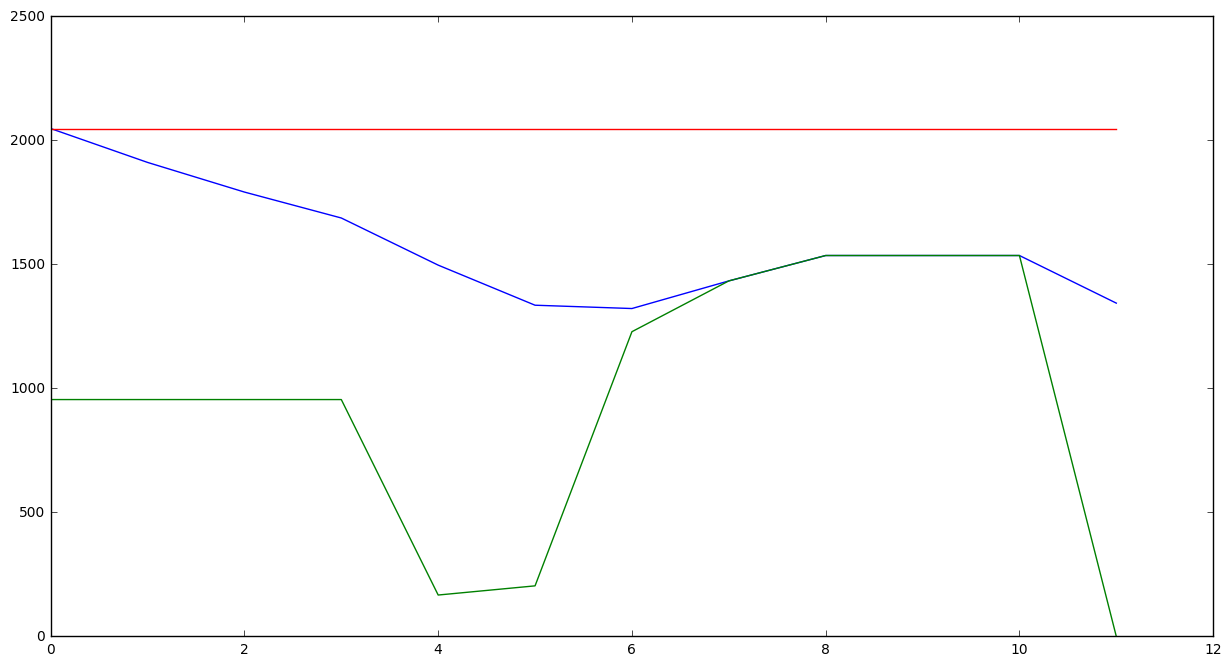

In [1177]:
first_con = con_queue.popAtLastPosition()
x = range(len(first_con.mem_estimated))
mem_resv = [first_con.resv_memory]*len(first_con.mem_estimated)
plt.plot(x, first_con.mem_estimated)
plt.plot(x, first_con.mem_used)
plt.plot(x, mem_resv)

In [1284]:

class node:
    nodeCount = 0
    
    def __init__(self, Node_Name, Mem_Capacity, CPU_Capacity, Mem_Allow, CPU_Allow):
        self.Node_Name = Node_Name
        self.lifetime = 0
        self.Node_Mode = "stopped" # "running" and "stopped"
        self.Mem_Capacity = Mem_Capacity
        self.CPU_Capacity = CPU_Capacity
        self.Mem_Allow = Mem_Allow
        self.CPU_Allow = CPU_Allow
        self.Mem_Allocated = []
        self.CPU_Allocated = []
        self.Mem_ActualUsed = []
        self.CPU_ActualUsed = []
        self.Mem_Estimated = [] #estimate on container
        self.CPU_Estimated = [] #estimate on container
        self.Mem_Est_Node = 0 #estimate on node
        self.CPU_Est_Node = 0 #estimate on node
        self.ReceivedContainers = container_queue()
        node.nodeCount += 1
        
    def run(self, lifetime):
        self.Node_Mode = "running"
        self.lifetime = lifetime
        self.Mem_Allocated = [0] * lifetime
        self.CPU_Allocated = [0] * lifetime
        self.Mem_ActualUsed = [0] * lifetime
        self.CPU_ActualUsed = [0] * lifetime
        self.Mem_Estimated = [0] * lifetime
        self.CPU_Estimated = [0] * lifetime
        # In a node lifetime, it has to handle load of the OS (Assume around 1 core and 1 Gig of mem)
        self.Mem_ActualUsed = [ x+1*1024 for x in self.Mem_ActualUsed ] #MB
        self.CPU_ActualUsed = [ x+1 for x in self.CPU_ActualUsed ]
        self.Mem_Est_Node = 0 #estimate on node
        self.CPU_Est_Node = 0 #estimate on node
        
    
    def stop(self):
        self.Node_Mode = "stopped"
        self.Mem_Allocated = []
        self.CPU_Allocated = []
        self.Mem_ActualUsed = []
        self.CPU_ActualUsed = []
    
    def _updateResourceUsage(self, container, arrivedtime):

        mem_allo = [container.resv_memory]*len(container.mem_used)
        cpu_allo = [container.resv_CPU]*len(container.cpu_used)
        
        mem_used = container.mem_used      
        cpu_used = container.cpu_used
            
        self.Mem_Allocated = adding_array(self.Mem_Allocated, mem_allo, arrivedtime)
        self.CPU_Allocated = adding_array(self.CPU_Allocated, cpu_allo, arrivedtime)
        self.Mem_ActualUsed = adding_array(self.Mem_ActualUsed, mem_used, arrivedtime)
        self.CPU_ActualUsed = adding_array(self.CPU_ActualUsed, cpu_used, arrivedtime)
    
    # Estimation on node =============== call every second
    def updateEstimationOnNode(self, atTimeT, alpha = 0.125):
        # if normal
        self.Mem_Est_Node = (1-alpha)*self.Mem_Est_Node + self.Mem_ActualUsed[atTimeT]*alpha
        self.CPU_Est_Node = (1-alpha)*self.CPU_Est_Node + self.CPU_ActualUsed[atTimeT]*alpha
        
        # Correct the estimation when resource usage bump up
        if self.Mem_Est_Node < self.Mem_ActualUsed[atTimeT]:
            self.Mem_Est_Node = self.Mem_ActualUsed[atTimeT]
        if self.CPU_Est_Node < self.CPU_ActualUsed[atTimeT]:
            self.CPU_Est_Node = self.CPU_ActualUsed[atTimeT]
            
        # In case alpha = 0, behave like the reservation model
        if alpha == 0:
            self.Mem_Est_Node = self.Mem_Allocated[atTimeT]
            self.CPU_Est_Node = self.CPU_Allocated[atTimeT]
    
    def _updateEstIfContainerCreated(self, container):
        # if there is container created
        self.Mem_Est_Node = self.Mem_Est_Node + container.resv_memory
        self.CPU_Est_Node = self.CPU_Est_Node + container.resv_CPU
        
    def setCurrentNodeEstimated(self, EMem, ECpu):
        self.Mem_Estimated_Node = EMem
        self.CPU_Estimated_Node = ECpu
        
    def getCurrentNodeEstimated(self):
        return self.Mem_Est_Node, self.CPU_Est_Node
    # ==============================================
        
    def _executeContainer(self, container, arrivedtime):
        self._updateResourceUsage(container, arrivedtime)
        self._updateEstimation(container, arrivedtime)
        self._updateEstIfContainerCreated(container)
    
    def receiveContainer(self, container, arrivedtime):
        self.ReceivedContainers.addToQueue(container, arrivedtime)
        self._executeContainer(container, arrivedtime)
    
    # Premption =========================
    def preemptContainer(self, container, policy):
        #TODO
        return False
    
    def standbyContainer(self, container):
        # memory is kept as is, CPU idle 
        return False
    
    def killContainer(self, container):
        # memory and CPU after kill time is removed
        kill_time = 0
        return False
    
    def waitContainer(self, container):
        # do nothing
        return True
    # ===================================
    
    def getCurrentResourceStatus(self, attimeT, mode = 'old'):
        if mode == 'old':
            return self.Mem_Capacity, self.CPU_Capacity,self.Mem_Allow, self.CPU_Allow,self.Mem_Allocated[attimeT], self.CPU_Allocated[attimeT],self.Mem_ActualUsed[attimeT], self.CPU_ActualUsed[attimeT]
        elif mode == 'new':
            return getNodeCapacity(), getNodeAllowance(), getNodeAllocated(attimeT), getCurrentUsage(self,attimeT) 
        elif mode == 'estimated':
            return getNodeCapacity(), getNodeAllowance(), getNodeAllocated(attimeT), getCurrentUsage(attimeT), getNodeEstimated(attimeT)
        else:
            print('Getting the resource status of node %s at time %d' % (self.Node_Name, attimeT))
            raise Exception('Mode \'%s\' is not available' % mode)
            
    def getCurrentUsage(self,attimeT):
        return self.Mem_ActualUsed[attimeT], self.CPU_ActualUsed[attimeT]
    
    def getNodeCapacity(self):
        return self.Mem_Capacity, self.CPU_Capacity
    
    def getNodeAllowance(self):
        return self.Mem_Allow, self.CPU_Allow
    
    def getNodeAllocated(self,attimeT):
        return self.Mem_Allocated[attimeT], self.CPU_Allocated[attimeT]
    
    # Estimation based on container ====== call when container is created
    def getNodeEstimated(self,attimeT):
        return self.Mem_Estimated[attimeT], self.CPU_Estimated[attimeT]
    
    def setNodeEstimated(self, Mem_Estimated, CPU_Estimated, attimeT):
        self.Mem_Estimated[attimeT] = Mem_Estimated
        self.CPU_Estimated[attimeT] = CPU_Estimated
    
    def _updateEstimation(self, container, arrivedtime):
        self.Mem_Estimated = adding_array(self.Mem_Estimated, container.mem_estimated, arrivedtime)
        self.CPU_Estimated = adding_array(self.CPU_Estimated, container.cpu_estimated, arrivedtime)
    # =====================================
    
    def displayNodeInfo(self):
        print ("Node Name: %s" % self.Node_Name)
        print ("Node Total Memory: %d" % self.Mem_Capacity)
        print ("Node Toal CPU %d" % self.CPU_Capacity)
        print ("Node Memory Allowable for Use: %d" % self.Mem_Allow)
        print ("Node CPU Allowable for Use: %d" % self.CPU_Allow)
    
    def displayNodeInfoAtTime(self, attimeT):
        if attimeT < len(self.lifetime):
            print ("Node Name: %s" % self.Node_Name)
            print ("Node Total Memory: %d" % self.Mem_Capacity)
            print ("Node Toal CPU %d" % self.CPU_Capacity)
            print ("Node Memory Allowable for Use: %d" % self.Mem_Allow)
            print ("Node CPU Allowable for Use: %d" % self.CPU_Allow)
            print ("Node Memory Allocated for Use: %d" % self.Mem_Allocated[ attimeT ])
            print ("Node CPU Allocated for Use: %d" % self.CPU_Allocated[ attimeT ])
            print ("Node Memory ActualUsage: %d" % self.Mem_ActualUsed[ attimeT ])
            print ("Node CPU ActualUsage: %d" % self.CPU_ActualUsed[ attimeT ])
        else:
            raise Exception('Resource query is out of node lifetime')
        

In [1179]:
debug = False
if debug == True:
    testnode = node('svr01',30000,10,20000,8)
    testcontainer = container('container_e100_1456319042576_0003_01_000054','application_1456319042576_0003',2048,1,12)
    testnode.run(50)
    arrivedtime = 10
    testnode.receiveContainer(testcontainer, arrivedtime, snapshot_dataframe,snapshot_mem_profile,snapshot_cpu_profile)
    print(testnode.Mem_Allocated)
    print(testnode.CPU_Allocated)
    print(testnode.Mem_ActualUsed)
    print(testnode.CPU_ActualUsed)


In [1285]:
class cluster:
    
    def __init__(self, cluster_name):
        self.cluster_name = cluster_name
        self.total_mem = 0
        self.total_core = 0
        self.allow_mem = 0
        self.allow_core = 0
        self.node_list = []
    
    def addNodeToCluster(self, node):
        self.node_list.append(node)
        self.total_mem += node.Mem_Capacity
        self.total_core += node.CPU_Capacity
        self.allow_mem += node.Mem_Allow
        self.allow_core += node.CPU_Allow
        
    def removeNodeFromCluster(self,node_name):
        node_index = -1
        for node in self.node_list:
            if node_name == node.Node_Name:
                node_index = self.node_list.index(node)
        if node_index >= 0: # Found node
            self.node_list.pop(node_index)
            self.total_mem -= node.Mem_Capacity
            self.total_core -= node.CPU_Capacity
            self.allow_mem -= node.Mem_Allow
            self.allow_core -= node.CPU_Allow
        else:
            raise Exception('Fail to find node in the cluster')
    
    def run(self, lifetime):
        for node in self.node_list:
            node.run(lifetime)
            
    def stop(self):
        for node in self.node_list:
            node.stop()
    
    def executeContainer(self, node, container, arrivedtime):
        found = False
        for nodeA in self.node_list:
            if nodeA == node:
                found = True
                nodeA.receiveContainer(container, arrivedtime)
        if found == False:
            raise Exception('Could not find node %s in cluster' % node.Node_Name )
            
    def getNodeResourceStatus(self, node, attimeT):
        Mem_Capacity, CPU_Capacity = node.getNodeCapacity()
        Mem_Allow, CPU_Allow = node.getNodeAllowance()
        Mem_Allocated, CPU_Allocated = node.getNodeAllocated(attimeT)
        Mem_ActualUsed, CPU_ActualUsed = node.getCurrentUsage(attimeT)
        return Mem_Capacity, CPU_Capacity,Mem_Allow, CPU_Allow,Mem_Allocated, CPU_Allocated,Mem_ActualUsed, CPU_ActualUsed
    
    def getClusterEstimated(self, attimeT):
        #attimeT actually is not needed, this function has to be called at the right time
        Mem_Est_lst = []
        CPU_Est_lst = []
        for node in self.node_list:
            Mem_Est, CPU_Est = node.getCurrentNodeEstimated()
            Mem_Est_lst.append(Mem_Est)
            CPU_Est_lst.append(CPU_Est)
        return Mem_Est_lst, CPU_Est_lst
    
    def getClusterEstimatedCon(self, attimeT):
        Mem_Est_lst = []
        CPU_Est_lst = []
        for node in self.node_list:
            Mem_Est, CPU_Est = node.getNodeEstimated(attimeT)
            Mem_Est_lst.append(Mem_Est)
            CPU_Est_lst.append(CPU_Est)
        return Mem_Est_lst, CPU_Est_lst
    
    def updateResourceEstimated(self, attimeT, alpha = 0.125):
        for node in self.node_list:
            node.updateEstimationOnNode(attimeT, alpha)
                
    def getClusterResourceStatus(self, attimeT):
        Time_lst = []
        Node_lst = []        
        Mem_Capacity_lst = []
        CPU_Capacity_lst = []
        Mem_Allow_lst = []
        CPU_Allow_lst = []
        Mem_Allocated_lst = []
        CPU_Allocated_lst = []
        Mem_ActualUsed_lst = []
        CPU_ActualUsed_lst = []
        for node in self.node_list:
            Mem_Capacity,CPU_Capacity,Mem_Allow,CPU_Allow,Mem_Allocated,CPU_Allocated,Mem_ActualUsed,CPU_ActualUsed = node.getCurrentResourceStatus(attimeT)
            Time_lst = Time_lst + [attimeT]
            Node_lst = Node_lst + [node.Node_Name]
            Mem_Capacity_lst = Mem_Capacity_lst + [Mem_Capacity]
            CPU_Capacity_lst = CPU_Capacity_lst + [CPU_Capacity]
            Mem_Allow_lst = Mem_Allow_lst + [Mem_Allow]
            CPU_Allow_lst = CPU_Allow_lst + [CPU_Allow]
            Mem_Allocated_lst = Mem_Allocated_lst + [Mem_Allocated]
            CPU_Allocated_lst = CPU_Allocated_lst + [CPU_Allocated]
            Mem_ActualUsed_lst = Mem_ActualUsed_lst + [Mem_ActualUsed]
            CPU_ActualUsed_lst = CPU_ActualUsed_lst + [CPU_ActualUsed]
        return Time_lst,Node_lst,Mem_Capacity_lst,CPU_Capacity_lst, Mem_Allow_lst,CPU_Allow_lst,Mem_Allocated_lst,CPU_Allocated_lst, Mem_ActualUsed_lst,CPU_ActualUsed_lst
        
    def displayClusterInfo(self):
        print ("Cluster Name: %s" % self.cluster_name)
        print ("Number of nodes in cluster: %d" % len(self.node_list))
        print ("Total Memory Capacity: %d" % self.total_mem)
        print ("Total CPU Capacity: %d" % self.total_core)
        print ("Total Memory allowable to use: %d" % self.allow_mem)
        print ("Total CPU allowable to use: %d" % self.allow_core)
    
    def displayNodeInfo(self):
        for node in self.node_list:
            print ("There are %d nodes in cluster %s" %(len(self.node_list), self.cluster_name))
            print ("=== node %s ===" % node.Node_Name)
            node.displayNodeInfo()

In [1181]:
#Test class:
## Define the nodes in the cluster
node1 = node( "svr01", 32768, 12, 28672, 10 )
node2 = node( "svr02", 32768, 12, 28672, 10 )
node3 = node( "svr03", 32768, 12, 28672, 10 )
node4 = node( "svr04", 32768, 12, 28672, 10 )
node5 = node( "svr05", 32768, 12, 28672, 10 )
node6 = node( "svr06", 32768, 12, 28672, 10 )

## Define the cluster and add nodes to the cluster
cluster1 = cluster("SPO")
cluster1.addNodeToCluster(node1)
cluster1.addNodeToCluster(node2)
cluster1.addNodeToCluster(node3)
cluster1.addNodeToCluster(node4)
cluster1.addNodeToCluster(node5)
cluster1.addNodeToCluster(node6)
cluster1.displayNodeInfo()
cluster1.displayClusterInfo()

There are 6 nodes in cluster SPO
=== node svr01 ===
Node Name: svr01
Node Total Memory: 32768
Node Toal CPU 12
Node Memory Allowable for Use: 28672
Node CPU Allowable for Use: 10
There are 6 nodes in cluster SPO
=== node svr02 ===
Node Name: svr02
Node Total Memory: 32768
Node Toal CPU 12
Node Memory Allowable for Use: 28672
Node CPU Allowable for Use: 10
There are 6 nodes in cluster SPO
=== node svr03 ===
Node Name: svr03
Node Total Memory: 32768
Node Toal CPU 12
Node Memory Allowable for Use: 28672
Node CPU Allowable for Use: 10
There are 6 nodes in cluster SPO
=== node svr04 ===
Node Name: svr04
Node Total Memory: 32768
Node Toal CPU 12
Node Memory Allowable for Use: 28672
Node CPU Allowable for Use: 10
There are 6 nodes in cluster SPO
=== node svr05 ===
Node Name: svr05
Node Total Memory: 32768
Node Toal CPU 12
Node Memory Allowable for Use: 28672
Node CPU Allowable for Use: 10
There are 6 nodes in cluster SPO
=== node svr06 ===
Node Name: svr06
Node Total Memory: 32768
Node Toal C

In [1286]:
import copy
class scheduler:
    scheduler_name = "FIFO"
    
    def __init__(self, cluster, mode='reservation'):
        self.cluster = cluster
        self.scheduler_queue = container_queue()
        self.scheduler_mode = mode # real_free, reservation
        self.executing_list = []
    
    def receiveContainers(self, container_queue):
        self.scheduler_queue = copy.deepcopy(container_queue)
    
    def _update_resource_estimation(self, node, attimeT, alpha=0.125):
        curMem, curCpu = node.getCurrentUsage(attimeT)
        curEMem, curECpu = node.getEstimated(attimeT)
        
        newEMem = (1-alpha)*EMem + alpha*curMem
        newECpu = (1-alpha)*ECpu + alpha*curCpu
        return newEMem, newECpu
    
    def _resource_satisfied(self, container, node, attimeT):
        mem_cap,cpu_cap,node_mem_allow,node_cpu_allow,node_resv_mem,node_resv_cpu,act_mem,act_cpu = node.getCurrentResourceStatus(attimeT)
        
        if self.scheduler_mode == 'reservation_based':
            node_free_mem = node_mem_allow - node_resv_mem #traditional
            node_free_cpu = node_cpu_allow - node_resv_cpu #traditional
        elif self.scheduler_mode == 'real_free_from_cap':
            node_free_mem = mem_cap - act_mem # allocate based on actual free memory
            node_free_cpu = cpu_cap - act_cpu # allocate based on actual free memory
        elif self.scheduler_mode == 'real_free_from_allow':
            node_free_mem = node_mem_allow - act_mem # allocate based on actual free memory from allowed memory
            node_free_cpu = node_cpu_allow - act_cpu # allocate based on actual free memory
        elif self.scheduler_mode == 'container_estimation_based':
            EMem, ECpu = node.getNodeEstimated(attimeT)
            node_free_mem = node_mem_allow - EMem
            node_free_cpu = node_cpu_allow - ECpu
        elif self.scheduler_mode == 'node_estimation_based':
            EMem, ECpu = node.getCurrentNodeEstimated()
            node_free_mem = node_mem_allow - EMem 
            node_free_cpu = node_cpu_allow - ECpu 
            
        if debug == True:
            print('Node free memory vs container need: %d vs %d' % (node_free_mem,container.resv_memory))    
            print('Node free cpu vs container need: %d vs %d' % (node_free_cpu, container.resv_CPU))
        
        point = self._calculate_matching_point(node_free_mem, node_free_cpu)
        
        if (container.resv_memory <= node_free_mem) and (container.resv_CPU <= node_free_cpu):
            return point
        else:
            return -1
    
    def _calculate_matching_point(self, free_mem, free_cpu):
        return free_mem/1024 + free_cpu
    
    def _calculateNodeSuitabilityIndex(self, container, attimeT):                
        node_index = 0
        node_most_suited_index = 0
        max_point = 0
        satisfied_nodes = []
        for node in self.cluster.node_list:
            node_point = self._resource_satisfied(container, node, attimeT)
            #print("Node %s has %d points" %(node.Node_Name, node_point))
            if  node_point > 0:
                if debug == True:
                    print('Found node %s satisfied the requirement' % node.Node_Name)
                satisfied_nodes.append(node)
                if node_point > max_point:
                    node_most_suited_index = node_index
                    max_point = node_point
                node_index += 1
        if debug == True:
            print("Most suited index: %d" % node_most_suited_index)
        if not satisfied_nodes:
            return None 
        else:
            return satisfied_nodes[node_most_suited_index]
    
    def preemptPolicy(self, container):
        KILL = 1
        STANDBY = 2
        WAIT = 3
        
        #assume in practice that we know the container finish time (impossible in practice)
        
        #if container type is application master, wait
        #if container finishes more than 75%, wait
        #if container finishes more than 40%, standby
        #else kill
        #default
        return WAIT
        
    def _getListOfContainerToExecute(self, attimeT):
        executing_list = self.executing_list # previous container that can be executed
        self.executing_list = [] #reset this list
        if not self.scheduler_queue.empty():
            container, arrivedTime = self.scheduler_queue.getFirstContainer()
        else:
            arrivedTime = 100000000000 #big number to ignore while loop
        while arrivedTime <= attimeT:
            if arrivedTime <= attimeT:
                container = self.scheduler_queue.popAtFirstPosition() # remove container
                executing_list.append(container) # append to executing list
            if not self.scheduler_queue.empty():
                container, arrivedTime = self.scheduler_queue.getFirstContainer() #for next round
            else:
                arrivedTime = 100000000000 #big number to ignore while loop
        return executing_list
        
    def execute(self, attimeT, alpha = 0.125):
        
        columns = ['time','node','mem_cap','cpu_cap','mem_allow','cpu_allow',
                    'mem_resv','cpu_resv','mem_current','cpu_current', 'mem_est', 'cpu_est', 'con_mem_est', 'con_cpu_est']        
        # List of container to cannot execute at time t-1
        container_list = self._getListOfContainerToExecute(attimeT)
        if container_list:
            if debug == True:
                print('At time %d: there are %d containers to execute:' % (attimeT, len(container_list)))
        for container in container_list: # for all containers have arrived until this time            
            node = self._calculateNodeSuitabilityIndex(container, attimeT)
            if node != None:
                if debug == True:
                    print('deliver container %s to node %s' % (container.con_id,node.Node_Name))
                self.cluster.executeContainer(node, container, attimeT)
            else: #keep container for next time 
                self.executing_list.append(container)
        #get node estimated at time T
        self.cluster.updateResourceEstimated(attimeT, alpha)
        Mem_Est_Node, CPU_Est_Node = self.cluster.getClusterEstimated(attimeT)
        Mem_Est_Con, CPU_Est_Con = self.cluster.getClusterEstimatedCon(attimeT)
        Time,Nodes,Mem_Capacity,CPU_Capacity,Mem_Allow,CPU_Allow,Mem_Allocated,CPU_Allocated,Mem_ActualUsed,CPU_ActualUsed = self.cluster.getClusterResourceStatus(attimeT)
        DataSet = list(zip(Time,Nodes,Mem_Capacity,CPU_Capacity,Mem_Allow,CPU_Allow,Mem_Allocated,CPU_Allocated,
                            Mem_ActualUsed,CPU_ActualUsed,Mem_Est_Node,CPU_Est_Node,Mem_Est_Con,CPU_Est_Con))
        cluster_resource_status = pd.DataFrame(DataSet, columns=columns)
        return cluster_resource_status


In [ ]:
import time, sys

# update_progress() : Displays or updates a console progress bar
## Accepts a float between 0 and 1. Any int will be converted to a float.
## A value under 0 represents a 'halt'.
## A value at 1 or bigger represents 100%
def update_progress(progress):
    barLength = 10 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    try:
        sys.stdout.write(text)
        sys.stdout.flush()
    except Exception as e:
        print(e)

In [1287]:
class simulator:
    
    def __init__(self, time):
        self.time = time # simulator lifetime
    
    def run(self, scheduler, container_queue, alpha = 0.125):
        # create empty table to receive simulated result
        columns = ['time','node','mem_cap','cpu_cap','mem_allow','cpu_allow',
                    'mem_resv','cpu_resv','mem_current','cpu_current', 'mem_est', 'cpu_est', 'con_mem_est', 'con_cpu_est']
        cluster_resource_status = pd.DataFrame(columns=columns)
        # Scheduler receive containers
        scheduler.cluster.run(self.time) # run the cluster in 'time' seconds
        scheduler.receiveContainers(container_queue)
        for attimeT in range(0, self.time):
            update_progress(float(attimeT)/(self.time-1))
            cluster_resource_status_attimeT = scheduler.execute(int(attimeT), alpha)
            #append the resource status to status table
            cluster_resource_status = cluster_resource_status.append(cluster_resource_status_attimeT)
        scheduler.cluster.stop()
        return cluster_resource_status

## Preparing the data input queue 

In [753]:
# Preparing container queue for the simulator
queue = container_queue()
queue.generateContainerQueue(ContainerDF, snapshot_mem_profile, snapshot_cpu_profile)

Adding 17385/19727 containers to queue for simulation


## Test 1: Comparing between Reservation, Container Estimation, Node Estimation model

In [1184]:
debug = False
# Simulating Scenario

## Define the nodes in the cluster
node1 = node( "svr01", 32768, 24, 28672, 18 )
node2 = node( "svr02", 32768, 24, 28672, 18 )
node3 = node( "svr03", 32768, 24, 28672, 18 )
node4 = node( "svr04", 32768, 24, 28672, 18 )
node5 = node( "svr05", 32768, 24, 28672, 18 )
node6 = node( "svr06", 32768, 24, 28672, 18 )
node7 = node( "svr07", 32768, 24, 28672, 18 )
node8 = node( "svr08", 32768, 24, 28672, 18 )

## Define the cluster and add nodes to the cluster
cluster2 = cluster('SPO2')
cluster2.addNodeToCluster(node1)
cluster2.addNodeToCluster(node2)
cluster2.addNodeToCluster(node3)
cluster2.addNodeToCluster(node4)
cluster2.addNodeToCluster(node5)
cluster2.addNodeToCluster(node6)
cluster2.addNodeToCluster(node7)
cluster2.addNodeToCluster(node8)

cluster2.displayClusterInfo()

## Define the scheduler, and give the cluster and the list of container to the scheduler
node_est_scheduler = scheduler(cluster2, mode='node_estimation_based')
con_est_scheduler = scheduler(cluster2, mode='container_estimation_based')
resv_based_scheduler = scheduler(cluster2, mode='reservation_based')

## Define the simulator with it executing duration (in second)
fifo_simulator = simulator(5000)

Cluster Name: SPO2
Number of nodes in cluster: 8
Total Memory Capacity: 262144
Total CPU Capacity: 192
Total Memory allowable to use: 229376
Total CPU allowable to use: 144


In [1188]:
## Run the simulator with the reservation scheduler
reservation_cluster_simulated_result = fifo_simulator.run(resv_based_scheduler, queue)

Percent: [##########] 100% Done...2%   


In [1189]:
## Run the simulator with the node estimation scheduler
node_est_cluster_simulated_result = fifo_simulator.run(node_est_scheduler, queue)

Percent: [##########] 100% Done...2%   


In [1190]:
## Run the simulator with the container estimation scheduler
con_est_cluster_simulated_result = fifo_simulator.run(con_est_scheduler, queue)

Percent: [##########] 100% Done...2%   


In [975]:
## Hack for NaN value: #TODO: look for the reason that there is NaN value
if cluster_simulated_result.isnull().values.any():
    print('There is NaN value!')
    cluster_simulated_result = cluster_simulated_result.fillna(0)

[0, 200, 0, 30]

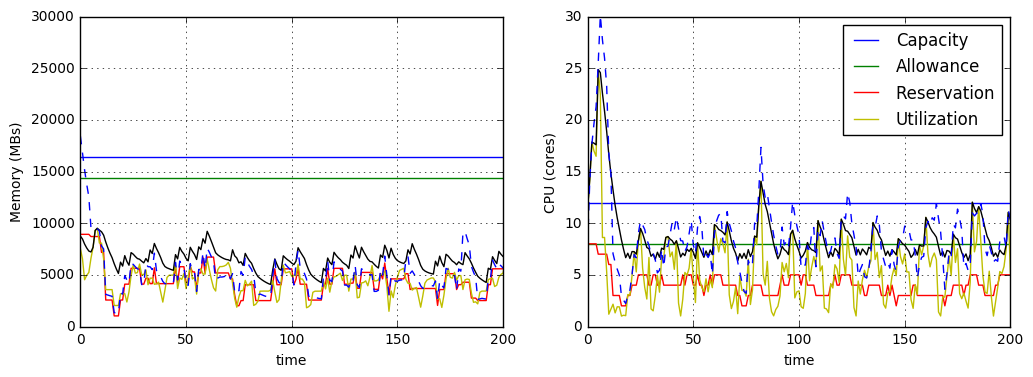

In [1147]:
## To plot figures for cluster: remove node column, then groupby 'time' and calculate sum => cluster usage during time
cluster_simulated_result_svr = node_est_cluster_simulated_result[(reservation_cluster_simulated_result.node == 'svr01')]
cluster_simulated_result_svr.head(n=10)

x = range(len(cluster_simulated_result_svr.mem_cap))
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.plot(x,cluster_simulated_result_svr.mem_cap,'-b')
ax.plot(x,cluster_simulated_result_svr.mem_allow,'-g')
ax.plot(x,cluster_simulated_result_svr.mem_resv,'-r')
ax.plot(x,cluster_simulated_result_svr.mem_current,'-y')
ax.plot(x,cluster_simulated_result_svr.mem_est,'-k')
#ax.plot(node1.Mem_Estimated, '--')
#ax.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'], loc = 1)
#ax.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'])
ax.set_xlabel('time')
ax.set_ylabel('Memory (MBs)')
ax.grid()
ax.axis([0,200,0,30000])

#cx = fig.add_subplot(312)
#count_lst = []
#for i in set(node1.ReceivedContainers.arrivetime):
#    appearance = node1.ReceivedContainers.arrivetime.count(i)
#    count_lst.insert(i,appearance)
#cx.plot(count_lst, 'o')
#cx.axis([0,100,0,8])

bx = fig.add_subplot(122)
bx.plot(x,cluster_simulated_result_svr.cpu_cap,'-b')
bx.plot(x,cluster_simulated_result_svr.cpu_allow,'-g')
bx.plot(x,cluster_simulated_result_svr.cpu_resv,'-r')
bx.plot(x,cluster_simulated_result_svr.cpu_current,'-y')
bx.plot(x,cluster_simulated_result_svr.cpu_est,'-k')
#bx.plot(node1.CPU_Estimated, '--')
#bx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
bx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'])
bx.set_xlabel('time')
bx.set_ylabel('CPU (cores)')
bx.grid()
bx.axis([0,200,0,30])

### View on One Node

[0, 5000, 0, 40]

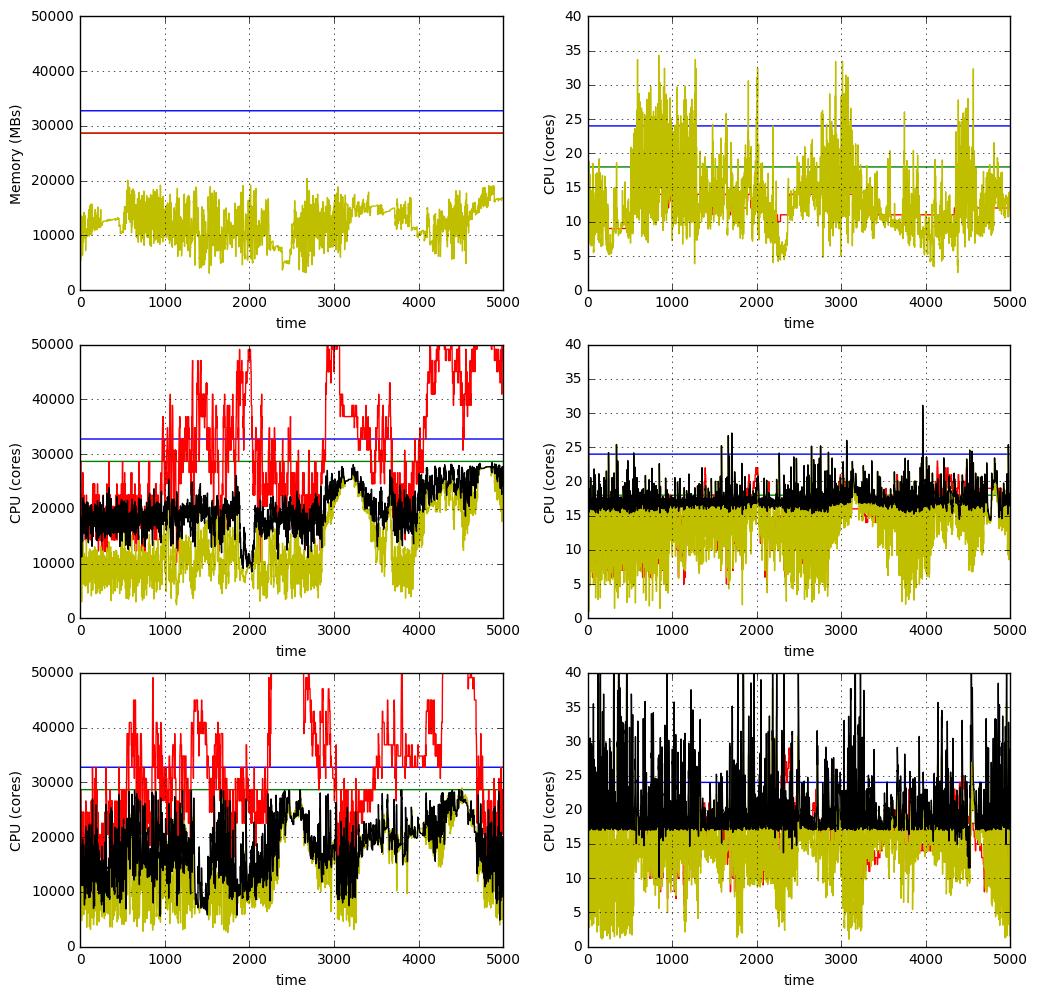

In [1204]:
nodename = "svr01"
timeln = 5000
reservation_cluster_simulated_result_svr = reservation_cluster_simulated_result[(reservation_cluster_simulated_result.node == nodename)]
node_est_cluster_simulated_result_svr = node_est_cluster_simulated_result[(node_est_cluster_simulated_result.node == nodename)]
con_est_cluster_simulated_result_svr = con_est_cluster_simulated_result[(con_est_cluster_simulated_result.node == nodename)]

x = range(len(reservation_cluster_simulated_result_svr.mem_cap))
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(321)
ax.plot(x,reservation_cluster_simulated_result_svr.mem_cap,'-b')
ax.plot(x,reservation_cluster_simulated_result_svr.mem_allow,'-g')
ax.plot(x,reservation_cluster_simulated_result_svr.mem_resv,'-r')
ax.plot(x,reservation_cluster_simulated_result_svr.mem_current,'-y')
#ax.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'], loc = 1)
#ax.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'])
ax.set_xlabel('time')
ax.set_ylabel('Memory (MBs)')
ax.grid()
ax.axis([0,timeln,0,50000])

#cx = fig.add_subplot(312)
#count_lst = []
#for i in set(node1.ReceivedContainers.arrivetime):
#    appearance = node1.ReceivedContainers.arrivetime.count(i)
#    count_lst.insert(i,appearance)
#cx.plot(count_lst, 'o')
#cx.axis([0,100,0,8])

bx = fig.add_subplot(322)
bx.plot(x,reservation_cluster_simulated_result_svr.cpu_cap,'-b')
bx.plot(x,reservation_cluster_simulated_result_svr.cpu_allow,'-g')
bx.plot(x,reservation_cluster_simulated_result_svr.cpu_resv,'-r')
bx.plot(x,reservation_cluster_simulated_result_svr.cpu_current,'-y')
#bx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#bx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
bx.set_xlabel('time')
bx.set_ylabel('CPU (cores)')
bx.grid()
bx.axis([0,timeln,0,40])

cx = fig.add_subplot(323)
cx.plot(x,node_est_cluster_simulated_result_svr.mem_cap,'-b')
cx.plot(x,node_est_cluster_simulated_result_svr.mem_allow,'-g')
cx.plot(x,node_est_cluster_simulated_result_svr.mem_resv,'-r')
cx.plot(x,node_est_cluster_simulated_result_svr.mem_current,'-y')
cx.plot(x,node_est_cluster_simulated_result_svr.mem_est,'-k')
#cx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#cx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
cx.set_xlabel('time')
cx.set_ylabel('CPU (cores)')
cx.grid()
cx.axis([0,timeln,0,50000])

dx = fig.add_subplot(324)
dx.plot(x,node_est_cluster_simulated_result_svr.cpu_cap,'-b')
dx.plot(x,node_est_cluster_simulated_result_svr.cpu_allow,'-g')
dx.plot(x,node_est_cluster_simulated_result_svr.cpu_resv,'-r')
dx.plot(x,node_est_cluster_simulated_result_svr.cpu_current,'-y')
dx.plot(x,node_est_cluster_simulated_result_svr.cpu_est,'-k')
#dx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#dx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
dx.set_xlabel('time')
dx.set_ylabel('CPU (cores)')
dx.grid()
dx.axis([0,timeln,0,40])

ex = fig.add_subplot(325)
ex.plot(x,con_est_cluster_simulated_result_svr.mem_cap,'-b')
ex.plot(x,con_est_cluster_simulated_result_svr.mem_allow,'-g')
ex.plot(x,con_est_cluster_simulated_result_svr.mem_resv,'-r')
ex.plot(x,con_est_cluster_simulated_result_svr.mem_current,'-y')
ex.plot(node1.Mem_Estimated, '-k')
#ex.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#ex.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
ex.set_xlabel('time')
ex.set_ylabel('CPU (cores)')
ex.grid()
ex.axis([0,timeln,0,50000])

fx = fig.add_subplot(326)
fx.plot(x,con_est_cluster_simulated_result_svr.cpu_cap,'-b')
fx.plot(x,con_est_cluster_simulated_result_svr.cpu_allow,'-g')
fx.plot(x,con_est_cluster_simulated_result_svr.cpu_resv,'-r')
fx.plot(x,con_est_cluster_simulated_result_svr.cpu_current,'-y')
fx.plot(node1.CPU_Estimated, '-k')
#fx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#fx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
fx.set_xlabel('time')
fx.set_ylabel('CPU (cores)')
fx.grid()
fx.axis([0,timeln,0,40])

### View on whole cluster

In [1194]:
resv_cluster_grp = reservation_cluster_simulated_result.groupby(by='time').sum()
node_est_cluster_grp = node_est_cluster_simulated_result.groupby(by='time').sum()
con_est_cluster_grp = con_est_cluster_simulated_result.groupby(by='time').sum()

[0, 3000, 0, 200]

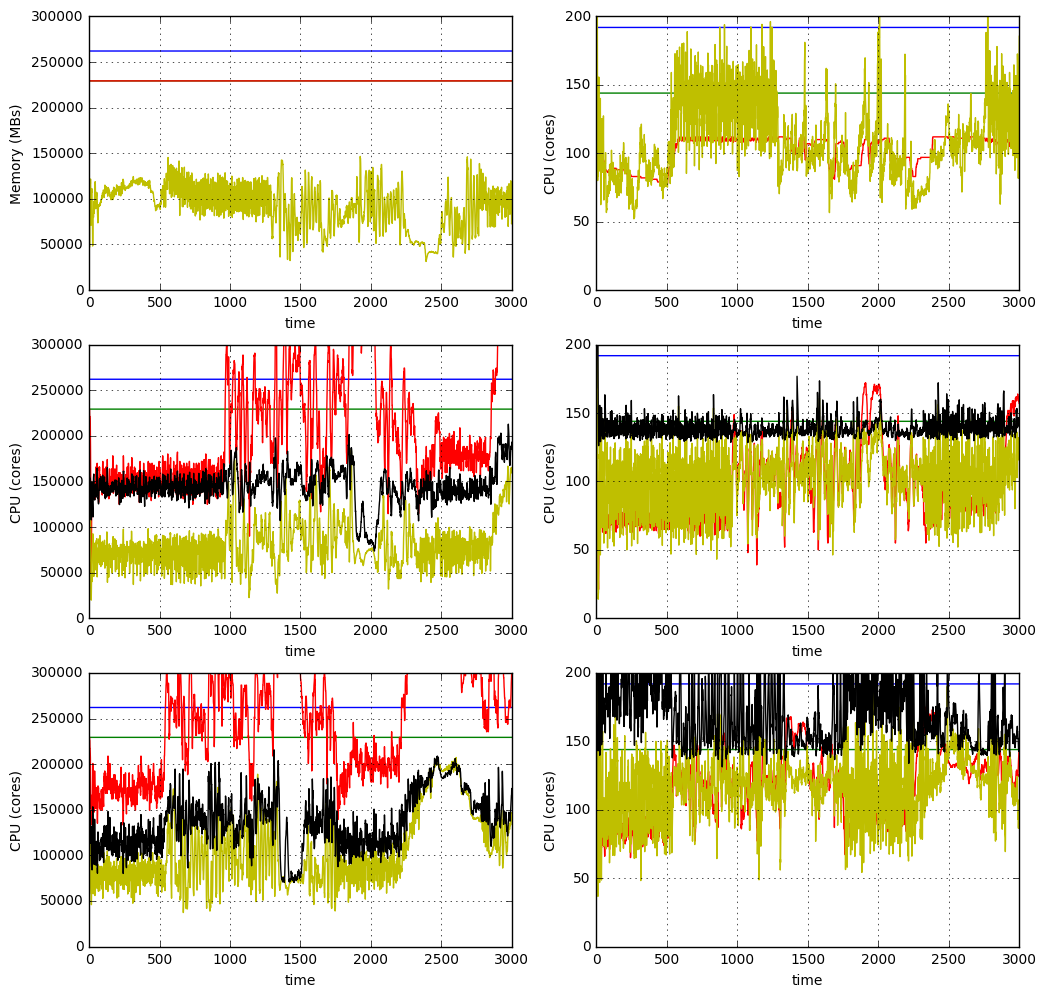

In [1203]:
timeln = 3000
x = range(len(resv_cluster_grp.mem_cap))
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(321)
ax.plot(x,resv_cluster_grp.mem_cap,'-b')
ax.plot(x,resv_cluster_grp.mem_allow,'-g')
ax.plot(x,resv_cluster_grp.mem_resv,'-r')
ax.plot(x,resv_cluster_grp.mem_current,'-y')
#ax.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'], loc = 1)
#ax.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'])
ax.set_xlabel('time')
ax.set_ylabel('Memory (MBs)')
ax.grid()
ax.axis([0,timeln,0,300000])

#cx = fig.add_subplot(312)
#count_lst = []
#for i in set(node1.ReceivedContainers.arrivetime):
#    appearance = node1.ReceivedContainers.arrivetime.count(i)
#    count_lst.insert(i,appearance)
#cx.plot(count_lst, 'o')
#cx.axis([0,100,0,8])

bx = fig.add_subplot(322)
bx.plot(x,resv_cluster_grp.cpu_cap,'-b')
bx.plot(x,resv_cluster_grp.cpu_allow,'-g')
bx.plot(x,resv_cluster_grp.cpu_resv,'-r')
bx.plot(x,resv_cluster_grp.cpu_current,'-y')
#bx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#bx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
bx.set_xlabel('time')
bx.set_ylabel('CPU (cores)')
bx.grid()
bx.axis([0,timeln,0,200])

cx = fig.add_subplot(323)
cx.plot(x,node_est_cluster_grp.mem_cap,'-b')
cx.plot(x,node_est_cluster_grp.mem_allow,'-g')
cx.plot(x,node_est_cluster_grp.mem_resv,'-r')
cx.plot(x,node_est_cluster_grp.mem_current,'-y')
cx.plot(x,node_est_cluster_grp.mem_est,'-k')
#cx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#cx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
cx.set_xlabel('time')
cx.set_ylabel('CPU (cores)')
cx.grid()
cx.axis([0,timeln,0,300000])

dx = fig.add_subplot(324)
dx.plot(x,node_est_cluster_grp.cpu_cap,'-b')
dx.plot(x,node_est_cluster_grp.cpu_allow,'-g')
dx.plot(x,node_est_cluster_grp.cpu_resv,'-r')
dx.plot(x,node_est_cluster_grp.cpu_current,'-y')
dx.plot(x,node_est_cluster_grp.cpu_est,'-k')
#dx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#dx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
dx.set_xlabel('time')
dx.set_ylabel('CPU (cores)')
dx.grid()
dx.axis([0,timeln,0,200])

ex = fig.add_subplot(325)
ex.plot(x,con_est_cluster_grp.mem_cap,'-b')
ex.plot(x,con_est_cluster_grp.mem_allow,'-g')
ex.plot(x,con_est_cluster_grp.mem_resv,'-r')
ex.plot(x,con_est_cluster_grp.mem_current,'-y')
ex.plot(x,con_est_cluster_grp.con_mem_est, '-k')
#ex.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#ex.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
ex.set_xlabel('time')
ex.set_ylabel('CPU (cores)')
ex.grid()
ex.axis([0,timeln,0,300000])

fx = fig.add_subplot(326)
fx.plot(x,con_est_cluster_grp.cpu_cap,'-b')
fx.plot(x,con_est_cluster_grp.cpu_allow,'-g')
fx.plot(x,con_est_cluster_grp.cpu_resv,'-r')
fx.plot(x,con_est_cluster_grp.cpu_current,'-y')
fx.plot(x,con_est_cluster_grp.con_cpu_est, '-k')
#fx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#fx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
fx.set_xlabel('time')
fx.set_ylabel('CPU (cores)')
fx.grid()
fx.axis([0,timeln,0,200])

In [1230]:
resv_cluster_grp.describe()

mem_cap  cpu_cap  mem_allow  cpu_allow  mem_resv   cpu_resv  \
count    5000.0   5000.0     5000.0     5000.0    5000.0  5000.0000   
mean   262144.0    192.0   229376.0      144.0  229376.0    99.6508   
std         0.0      0.0        0.0        0.0       0.0     9.9241   
min    262144.0    192.0   229376.0      144.0  229376.0    78.0000   
25%    262144.0    192.0   229376.0      144.0  229376.0    93.0000   
50%    262144.0    192.0   229376.0      144.0  229376.0    97.0000   
75%    262144.0    192.0   229376.0      144.0  229376.0   110.0000   
max    262144.0    192.0   229376.0      144.0  229376.0   112.0000   

         mem_current  cpu_current        mem_est      cpu_est    con_mem_est  \
count    5000.000000  5000.000000    5000.000000  5000.000000    5000.000000   
mean    99791.755858   103.978325  150489.670682   134.512912  122818.100597   
std     23232.152619    26.419635   39125.604215    39.143698   23096.593096   
min     31331.978600    48.384777   43934.471746    66.089728   35844.199409   
25%     87185.075819    84.512760  124429.047688   102.095453  109793.908854   
50%    104945.089441    98.752062  142406.289452   124.551480  123096.032720   
75%    116336.944299   120.153587  184788.769868   173.868040  140569.549422   
max    149872.899971   260.597000  251687.053593   267.929115  229376.000000   

       con_cpu_est  
count  5000.000000  
mean    151.564084  
std      58.059722  
min      66.297604  
25%     106.280387  
50%     130.265344  
75%     207.611724  
max     344.914982

In [1231]:
node_est_cluster_grp.describe()

mem_cap  cpu_cap  mem_allow  cpu_allow       mem_resv     cpu_resv  \
count    5000.0   5000.0     5000.0     5000.0    5000.000000  5000.000000   
mean   262144.0    192.0   229376.0      144.0  249172.377600   107.842000   
std         0.0      0.0        0.0        0.0   85710.428973    29.545382   
min    262144.0    192.0   229376.0      144.0   49152.000000    21.000000   
25%    262144.0    192.0   229376.0      144.0  169984.000000    80.000000   
50%    262144.0    192.0   229376.0      144.0  239616.000000   108.000000   
75%    262144.0    192.0   229376.0      144.0  319488.000000   133.000000   
max    262144.0    192.0   229376.0      144.0  503808.000000   173.000000   

         mem_current  cpu_current        mem_est      cpu_est    con_mem_est  \
count    5000.000000  5000.000000    5000.000000  5000.000000    5000.000000   
mean   110257.134795   109.439390  160068.338862   141.095430  133311.902140   
std     46761.385283    21.585897   27863.362960     9.532615   36112.953358   
min     19916.703788    13.960750   73707.146188   121.246431   26276.071419   
25%     73537.305316    96.031097  141055.988271   135.748988  102365.946873   
50%     90953.319035   110.946411  153504.019819   139.112112  126406.304295   
75%    155838.698929   124.875683  184503.615102   143.989803  167671.734105   
max    204884.033301   315.887636  218071.986906   322.041839  229376.000000   

       con_cpu_est  
count  5000.000000  
mean    157.839680  
std      22.320229  
min      40.643816  
25%     146.788014  
50%     159.035141  
75%     170.717029  
max     397.320808

In [1232]:
con_est_cluster_grp.describe()

mem_cap  cpu_cap  mem_allow  cpu_allow       mem_resv    cpu_resv  \
count    5000.0   5000.0     5000.0     5000.0    5000.000000  5000.00000   
mean   262144.0    192.0   229376.0      144.0  280402.329600   119.04960   
std         0.0      0.0        0.0        0.0   82918.536609    24.98915   
min    262144.0    192.0   229376.0      144.0  133120.000000    65.00000   
25%    262144.0    192.0   229376.0      144.0  204800.000000    96.00000   
50%    262144.0    192.0   229376.0      144.0  278528.000000   121.00000   
75%    262144.0    192.0   229376.0      144.0  339968.000000   138.00000   
max    262144.0    192.0   229376.0      144.0  552960.000000   178.00000   

         mem_current  cpu_current        mem_est      cpu_est    con_mem_est  \
count    5000.000000  5000.000000    5000.000000  5000.000000    5000.000000   
mean   124658.717300   118.780278  176374.747540   155.579889  148334.676793   
std     45221.337691    20.618033   29818.704020    16.553421   33363.866422   
min     37244.645746    36.684261   78226.282707   111.355025   70226.788770   
25%     85068.848770   107.181851  157105.432622   144.049907  120743.417119   
50%    116014.058029   120.522079  175949.778321   154.411800  147296.259289   
75%    167461.617974   131.568822  198246.972384   165.642991  176821.935725   
max    208721.306820   287.416195  271588.803508   290.807676  229376.000000   

       con_cpu_est  
count  5000.000000  
mean    169.170441  
std      22.837750  
min     108.000000  
25%     151.359662  
50%     163.899271  
75%     182.842822  
max     365.943700

### II. When memory is the bottleneck (the case of perfect users)

For the case of perfect user, the reservation model would protect the container from broken because of lack of memory. However, this would be very bad for our scheduler. Reasons?
#TODO

In [774]:
### What if the reservation was done perfectly? reservation = max_used
perfect_queue = container_queue()
perfect_queue.generateContainerQueue(ContainerDF, snapshot_mem_profile, snapshot_cpu_profile, perfect_resv = True)

Adding 17385/19727 containers to queue for simulation


In [1296]:
## Define the nodes in the cluster
mem_cap = 32768 # 32GBs
cpu_cap = 64
mem_desired = 28672 # 28GBs
cpu_desired = 56

node21 = node( "svr21", mem_cap, cpu_cap, mem_desired, cpu_desired )
node22 = node( "svr22", mem_cap, cpu_cap, mem_desired, cpu_desired )
node23 = node( "svr23", mem_cap, cpu_cap, mem_desired, cpu_desired )
node24 = node( "svr24", mem_cap, cpu_cap, mem_desired, cpu_desired )
node25 = node( "svr25", mem_cap, cpu_cap, mem_desired, cpu_desired )
node26 = node( "svr26", mem_cap, cpu_cap, mem_desired, cpu_desired )
node27 = node( "svr27", mem_cap, cpu_cap, mem_desired, cpu_desired )
node28 = node( "svr28", mem_cap, cpu_cap, mem_desired, cpu_desired )

## Define the cluster and add nodes to the cluster
cluster4 = cluster('SPO4')
cluster4.addNodeToCluster(node21)
cluster4.addNodeToCluster(node22)
cluster4.addNodeToCluster(node23)
cluster4.addNodeToCluster(node24)
cluster4.addNodeToCluster(node25)
cluster4.addNodeToCluster(node26)
cluster4.addNodeToCluster(node27)
cluster4.addNodeToCluster(node28)

cluster4.displayClusterInfo()

## Define the scheduler, and give the cluster and the list of container to the scheduler
node_est_membtn_scheduler = scheduler(cluster4, mode='node_estimation_based')
con_est_membtn_scheduler = scheduler(cluster4, mode='container_estimation_based')
resv_based_membtn_scheduler = scheduler(cluster4, mode='reservation_based')

## Define the simulator with it executing duration (in second)
membtn_simulator = simulator(5000)

Cluster Name: SPO4
Number of nodes in cluster: 8
Total Memory Capacity: 262144
Total CPU Capacity: 512
Total Memory allowable to use: 229376
Total CPU allowable to use: 448


In [1297]:
resv_based_membtn_cluster_result = membtn_simulator.run(resv_based_membtn_scheduler, perfect_queue)
node_est_membtn_cluster_result = membtn_simulator.run(node_est_membtn_scheduler, perfect_queue)
con_est_membtn_cluster_result = membtn_simulator.run(con_est_membtn_scheduler, perfect_queue)

Percent: [##########] 100% Done...2%   
Percent: [##########] 100% Done...2%   
Percent: [##########] 100% Done...2%   


In [1309]:

resv_based_membtn_cluster_grp = resv_based_membtn_cluster_result.groupby(by='time').sum()
resv_based_membtn_cluster_grp[['mem_cap','mem_allow','mem_resv','mem_current',
                               'mem_est','con_mem_est']] = resv_based_membtn_cluster_grp[['mem_cap','mem_allow',
                                                               'mem_resv','mem_current',
                                                                'mem_est','con_mem_est']].div(1024,axis = 0)
node_est_membtn_cluster_grp = node_est_membtn_cluster_result.groupby(by='time').sum()
node_est_membtn_cluster_grp[['mem_cap','mem_allow','mem_resv','mem_current',
                               'mem_est','con_mem_est']] = node_est_membtn_cluster_grp[['mem_cap','mem_allow',
                                                               'mem_resv','mem_current',
                                                                'mem_est','con_mem_est']].div(1024,axis = 0)
con_est_membtn_cluster_grp = con_est_membtn_cluster_result.groupby(by='time').sum()
con_est_membtn_cluster_grp[['mem_cap','mem_allow','mem_resv','mem_current',
                               'mem_est','con_mem_est']] = con_est_membtn_cluster_grp[['mem_cap','mem_allow',
                                                               'mem_resv','mem_current',
                                                                'mem_est','con_mem_est']].div(1024,axis = 0)

[0, 5000, 0, 600]

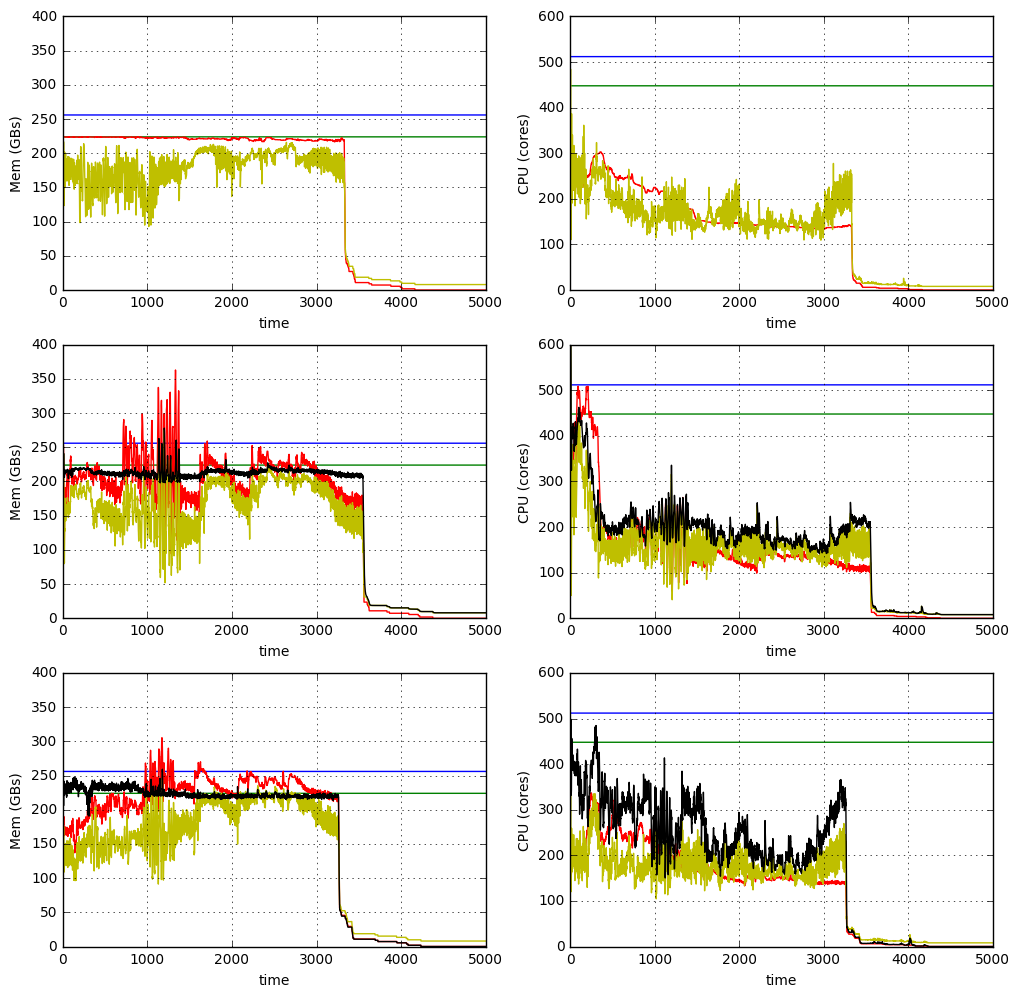

In [1304]:
timeln = 5000
coremax = 600
memmax = 400
x = range(len(resv_based_membtn_cluster_grp.mem_cap))
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(321)
ax.plot(x,resv_based_membtn_cluster_grp.mem_cap,'-b')
ax.plot(x,resv_based_membtn_cluster_grp.mem_allow,'-g')
ax.plot(x,resv_based_membtn_cluster_grp.mem_resv,'-r')
ax.plot(x,resv_based_membtn_cluster_grp.mem_current,'-y')
#ax.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'], loc = 1)
#ax.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'])
ax.set_xlabel('time')
ax.set_ylabel('Mem (GBs)')
ax.grid()
ax.axis([0,timeln,0,memmax])

#cx = fig.add_subplot(312)
#count_lst = []
#for i in set(node1.ReceivedContainers.arrivetime):
#    appearance = node1.ReceivedContainers.arrivetime.count(i)
#    count_lst.insert(i,appearance)
#cx.plot(count_lst, 'o')
#cx.axis([0,100,0,8])

bx = fig.add_subplot(322)
bx.plot(x,resv_based_membtn_cluster_grp.cpu_cap,'-b')
bx.plot(x,resv_based_membtn_cluster_grp.cpu_allow,'-g')
bx.plot(x,resv_based_membtn_cluster_grp.cpu_resv,'-r')
bx.plot(x,resv_based_membtn_cluster_grp.cpu_current,'-y')
#bx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#bx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
bx.set_xlabel('time')
bx.set_ylabel('CPU (cores)')
bx.grid()
bx.axis([0,timeln,0,coremax])

cx = fig.add_subplot(323)
cx.plot(x,node_est_membtn_cluster_grp.mem_cap,'-b')
cx.plot(x,node_est_membtn_cluster_grp.mem_allow,'-g')
cx.plot(x,node_est_membtn_cluster_grp.mem_resv,'-r')
cx.plot(x,node_est_membtn_cluster_grp.mem_current,'-y')
cx.plot(x,node_est_membtn_cluster_grp.mem_est,'-k')
#cx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#cx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
cx.set_xlabel('time')
cx.set_ylabel('Mem (GBs)')
cx.grid()
cx.axis([0,timeln,0,memmax])

dx = fig.add_subplot(324)
dx.plot(x,node_est_membtn_cluster_grp.cpu_cap,'-b')
dx.plot(x,node_est_membtn_cluster_grp.cpu_allow,'-g')
dx.plot(x,node_est_membtn_cluster_grp.cpu_resv,'-r')
dx.plot(x,node_est_membtn_cluster_grp.cpu_current,'-y')
dx.plot(x,node_est_membtn_cluster_grp.cpu_est,'-k')
#dx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#dx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
dx.set_xlabel('time')
dx.set_ylabel('CPU (cores)')
dx.grid()
dx.axis([0,timeln,0,coremax])

ex = fig.add_subplot(325)
ex.plot(x,con_est_membtn_cluster_grp.mem_cap,'-b')
ex.plot(x,con_est_membtn_cluster_grp.mem_allow,'-g')
ex.plot(x,con_est_membtn_cluster_grp.mem_resv,'-r')
ex.plot(x,con_est_membtn_cluster_grp.mem_current,'-y')
ex.plot(x,con_est_membtn_cluster_grp.con_mem_est, '-k')
#ex.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#ex.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
ex.set_xlabel('time')
ex.set_ylabel('Mem (GBs)')
ex.grid()
ex.axis([0,timeln,0,memmax])

fx = fig.add_subplot(326)
fx.plot(x,con_est_membtn_cluster_grp.cpu_cap,'-b')
fx.plot(x,con_est_membtn_cluster_grp.cpu_allow,'-g')
fx.plot(x,con_est_membtn_cluster_grp.cpu_resv,'-r')
fx.plot(x,con_est_membtn_cluster_grp.cpu_current,'-y')
fx.plot(x,con_est_membtn_cluster_grp.con_cpu_est, '-k')
#fx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#fx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
fx.set_xlabel('time')
fx.set_ylabel('CPU (cores)')
fx.grid()
fx.axis([0,timeln,0,coremax])

[0, 4500, 0, 70]

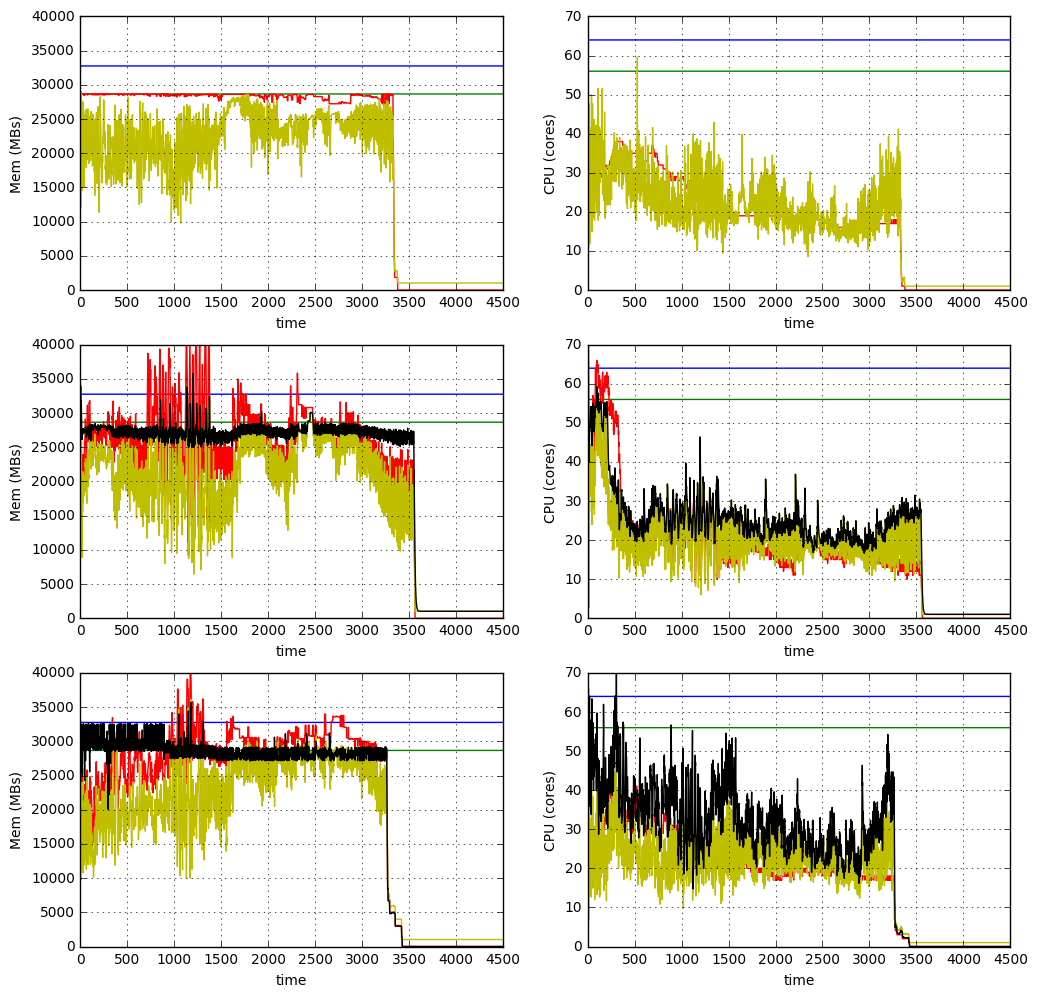

In [1313]:
SelectedNode = 'svr22'
resv_based_membtn_svr_result = resv_based_membtn_cluster_result[(resv_based_membtn_cluster_result.node == SelectedNode)]
#resv_based_membtn_svr_result[['mem_cap','mem_allow','mem_resv','mem_current',
#                               'mem_est','con_mem_est']] = resv_based_membtn_svr_result[['mem_cap','mem_allow',
#                                                               'mem_resv','mem_current',
#                                                                'mem_est','con_mem_est']].div(1024,axis = 0)
node_est_membtn_svr_result = node_est_membtn_cluster_result[(node_est_membtn_cluster_result.node == SelectedNode)]
#node_est_membtn_svr_result[['mem_cap','mem_allow','mem_resv','mem_current',
#                               'mem_est','con_mem_est']] = node_est_membtn_svr_result[['mem_cap','mem_allow',
#                                                               'mem_resv','mem_current',
#                                                                'mem_est','con_mem_est']].div(1024,axis = 0)
con_est_membtn_svr_result = con_est_membtn_cluster_result[(con_est_membtn_cluster_result.node == SelectedNode)]
#con_est_membtn_svr_result[['mem_cap','mem_allow','mem_resv','mem_current',
#                               'mem_est','con_mem_est']] = con_est_membtn_svr_result[['mem_cap','mem_allow',
#                                                               'mem_resv','mem_current',
#                                                                'mem_est','con_mem_est']].div(1024,axis = 0)

timeln = 4500
coremax = 70
memmax = 40000
x = range(len(resv_based_membtn_svr_result.mem_cap))
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(321)
ax.plot(x,resv_based_membtn_svr_result.mem_cap,'-b')
ax.plot(x,resv_based_membtn_svr_result.mem_allow,'-g')
ax.plot(x,resv_based_membtn_svr_result.mem_resv,'-r')
ax.plot(x,resv_based_membtn_svr_result.mem_current,'-y')
#ax.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'], loc = 1)
#ax.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'])
ax.set_xlabel('time')
ax.set_ylabel('Mem (MBs)')
ax.grid()
ax.axis([0,timeln,0,memmax])

#cx = fig.add_subplot(312)
#count_lst = []
#for i in set(node1.ReceivedContainers.arrivetime):
#    appearance = node1.ReceivedContainers.arrivetime.count(i)
#    count_lst.insert(i,appearance)
#cx.plot(count_lst, 'o')
#cx.axis([0,100,0,8])

bx = fig.add_subplot(322)
bx.plot(x,resv_based_membtn_svr_result.cpu_cap,'-b')
bx.plot(x,resv_based_membtn_svr_result.cpu_allow,'-g')
bx.plot(x,resv_based_membtn_svr_result.cpu_resv,'-r')
bx.plot(x,resv_based_membtn_svr_result.cpu_current,'-y')
#bx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#bx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
bx.set_xlabel('time')
bx.set_ylabel('CPU (cores)')
bx.grid()
bx.axis([0,timeln,0,coremax])

cx = fig.add_subplot(323)
cx.plot(x,node_est_membtn_svr_result.mem_cap,'-b')
cx.plot(x,node_est_membtn_svr_result.mem_allow,'-g')
cx.plot(x,node_est_membtn_svr_result.mem_resv,'-r')
cx.plot(x,node_est_membtn_svr_result.mem_current,'-y')
cx.plot(x,node_est_membtn_svr_result.mem_est,'-k')
#cx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#cx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
cx.set_xlabel('time')
cx.set_ylabel('Mem (MBs)')
cx.grid()
cx.axis([0,timeln,0,memmax])

dx = fig.add_subplot(324)
dx.plot(x,node_est_membtn_svr_result.cpu_cap,'-b')
dx.plot(x,node_est_membtn_svr_result.cpu_allow,'-g')
dx.plot(x,node_est_membtn_svr_result.cpu_resv,'-r')
dx.plot(x,node_est_membtn_svr_result.cpu_current,'-y')
dx.plot(x,node_est_membtn_svr_result.cpu_est,'-k')
#dx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#dx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
dx.set_xlabel('time')
dx.set_ylabel('CPU (cores)')
dx.grid()
dx.axis([0,timeln,0,coremax])

ex = fig.add_subplot(325)
ex.plot(x,con_est_membtn_svr_result.mem_cap,'-b')
ex.plot(x,con_est_membtn_svr_result.mem_allow,'-g')
ex.plot(x,con_est_membtn_svr_result.mem_resv,'-r')
ex.plot(x,con_est_membtn_svr_result.mem_current,'-y')
ex.plot(x,con_est_membtn_svr_result.con_mem_est, '-k')
#ex.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#ex.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
ex.set_xlabel('time')
ex.set_ylabel('Mem (MBs)')
ex.grid()
ex.axis([0,timeln,0,memmax])

fx = fig.add_subplot(326)
fx.plot(x,con_est_membtn_svr_result.cpu_cap,'-b')
fx.plot(x,con_est_membtn_svr_result.cpu_allow,'-g')
fx.plot(x,con_est_membtn_svr_result.cpu_resv,'-r')
fx.plot(x,con_est_membtn_svr_result.cpu_current,'-y')
fx.plot(x,con_est_membtn_svr_result.con_cpu_est, '-k')
#fx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#fx.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], mode="expand", ncol=4)
fx.set_xlabel('time')
fx.set_ylabel('CPU (cores)')
fx.grid()
fx.axis([0,timeln,0,coremax])

### III. When CPU is the bottleneck 

#### III.1. Generate container Queue

In [1252]:
cpu_bottleneck00_queue = container_queue()
cpu_bottleneck00_queue.generateContainerQueue(ContainerDF.head(n=5000), snapshot_mem_profile, snapshot_cpu_profile, est_alpha = 0)

Adding 4427/5000 containers to queue for simulation


In [1253]:
cpu_bottleneck01_queue = container_queue()
cpu_bottleneck01_queue.generateContainerQueue(ContainerDF.head(n=5000), snapshot_mem_profile, snapshot_cpu_profile, est_alpha = 0.1)

Adding 4427/5000 containers to queue for simulation


In [1254]:
cpu_bottleneck02_queue = container_queue()
cpu_bottleneck02_queue.generateContainerQueue(ContainerDF.head(n=5000), snapshot_mem_profile, snapshot_cpu_profile, est_alpha = 0.2)

Adding 4427/5000 containers to queue for simulation


In [1217]:
cpu_bottleneck03_queue = container_queue()
cpu_bottleneck03_queue.generateContainerQueue(ContainerDF.head(n=5000), snapshot_mem_profile, snapshot_cpu_profile, est_alpha = 0.3)

Adding 4427/5000 containers to queue for simulation


In [1218]:
cpu_bottleneck04_queue = container_queue()
cpu_bottleneck04_queue.generateContainerQueue(ContainerDF.head(n=5000), snapshot_mem_profile, snapshot_cpu_profile, est_alpha = 0.4)

Adding 4427/5000 containers to queue for simulation


In [1219]:
cpu_bottleneck05_queue = container_queue()
cpu_bottleneck05_queue.generateContainerQueue(ContainerDF.head(n=5000), snapshot_mem_profile, snapshot_cpu_profile, est_alpha = 0.5)

Adding 4427/5000 containers to queue for simulation


In [1220]:
cpu_bottleneck06_queue = container_queue()
cpu_bottleneck06_queue.generateContainerQueue(ContainerDF.head(n=5000), snapshot_mem_profile, snapshot_cpu_profile, est_alpha = 0.6)

Adding 4427/5000 containers to queue for simulation


In [1221]:
cpu_bottleneck07_queue = container_queue()
cpu_bottleneck07_queue.generateContainerQueue(ContainerDF.head(n=5000), snapshot_mem_profile, snapshot_cpu_profile, est_alpha = 0.7)

Adding 4427/5000 containers to queue for simulation


In [1222]:
cpu_bottleneck08_queue = container_queue()
cpu_bottleneck08_queue.generateContainerQueue(ContainerDF.head(n=5000), snapshot_mem_profile, snapshot_cpu_profile, est_alpha = 0.8)

Adding 4427/5000 containers to queue for simulation


In [1223]:
cpu_bottleneck09_queue = container_queue()
cpu_bottleneck09_queue.generateContainerQueue(ContainerDF.head(n=5000), snapshot_mem_profile, snapshot_cpu_profile, est_alpha = 0.9)

Adding 4427/5000 containers to queue for simulation


In [1224]:
cpu_bottleneck10_queue = container_queue()
cpu_bottleneck10_queue.generateContainerQueue(ContainerDF.head(n=5000), snapshot_mem_profile, snapshot_cpu_profile, est_alpha = 1)

Adding 4427/5000 containers to queue for simulation


#### III.2 Generate Cluster

In [1288]:
## Define the nodes in the cluster
mem_cap = 98304 # 96GBs
cpu_cap = 24
mem_desired = 92160 # 90GBs
cpu_desired = 20

node11 = node( "svr11", mem_cap, cpu_cap, mem_desired, cpu_desired )
node12 = node( "svr12", mem_cap, cpu_cap, mem_desired, cpu_desired )
node13 = node( "svr13", mem_cap, cpu_cap, mem_desired, cpu_desired )
node14 = node( "svr14", mem_cap, cpu_cap, mem_desired, cpu_desired )
node15 = node( "svr15", mem_cap, cpu_cap, mem_desired, cpu_desired )
node16 = node( "svr16", mem_cap, cpu_cap, mem_desired, cpu_desired )
node17 = node( "svr17", mem_cap, cpu_cap, mem_desired, cpu_desired )
node18 = node( "svr18", mem_cap, cpu_cap, mem_desired, cpu_desired )

## Define the cluster and add nodes to the cluster
cluster3 = cluster('SPO3')
cluster3.addNodeToCluster(node11)
cluster3.addNodeToCluster(node12)
cluster3.addNodeToCluster(node13)
cluster3.addNodeToCluster(node14)
cluster3.addNodeToCluster(node15)
cluster3.addNodeToCluster(node16)
cluster3.addNodeToCluster(node17)
cluster3.addNodeToCluster(node18)

cluster3.displayClusterInfo()

## Define the scheduler, and give the cluster and the list of container to the scheduler
node_est_cpubtn_scheduler = scheduler(cluster3, mode='node_estimation_based')
con_est_cpubtn_scheduler = scheduler(cluster3, mode='container_estimation_based')
resv_based_cpubtn_scheduler = scheduler(cluster3, mode='reservation_based')

## Define the simulator with it executing duration (in second)
cpubtn_simulator = simulator(1100)

Cluster Name: SPO3
Number of nodes in cluster: 8
Total Memory Capacity: 786432
Total CPU Capacity: 192
Total Memory allowable to use: 737280
Total CPU allowable to use: 160


In [1289]:
## Run the simulator with the node estimation scheduler
node_est_cpubtn00_cluster_result = cpubtn_simulator.run(node_est_cpubtn_scheduler, cpu_bottleneck00_queue, alpha = 0)
node_est_cpubtn01_cluster_result = cpubtn_simulator.run(node_est_cpubtn_scheduler, cpu_bottleneck01_queue, alpha = 0.1)
node_est_cpubtn02_cluster_result = cpubtn_simulator.run(node_est_cpubtn_scheduler, cpu_bottleneck02_queue, alpha = 0.2)
node_est_cpubtn03_cluster_result = cpubtn_simulator.run(node_est_cpubtn_scheduler, cpu_bottleneck03_queue, alpha = 0.3)
node_est_cpubtn04_cluster_result = cpubtn_simulator.run(node_est_cpubtn_scheduler, cpu_bottleneck04_queue, alpha = 0.4)
node_est_cpubtn05_cluster_result = cpubtn_simulator.run(node_est_cpubtn_scheduler, cpu_bottleneck05_queue, alpha = 0.5)
node_est_cpubtn06_cluster_result = cpubtn_simulator.run(node_est_cpubtn_scheduler, cpu_bottleneck06_queue, alpha = 0.6)
node_est_cpubtn07_cluster_result = cpubtn_simulator.run(node_est_cpubtn_scheduler, cpu_bottleneck07_queue, alpha = 0.7)
node_est_cpubtn08_cluster_result = cpubtn_simulator.run(node_est_cpubtn_scheduler, cpu_bottleneck08_queue, alpha = 0.8)
node_est_cpubtn09_cluster_result = cpubtn_simulator.run(node_est_cpubtn_scheduler, cpu_bottleneck09_queue, alpha = 0.9)
node_est_cpubtn10_cluster_result = cpubtn_simulator.run(node_est_cpubtn_scheduler, cpu_bottleneck10_queue, alpha = 1)

Percent: [##########] 100% Done...6%   
Percent: [##########] 100% Done...6%   
Percent: [##########] 100% Done...6%   
Percent: [##########] 100% Done...6%   
Percent: [##########] 100% Done...6%   
Percent: [##########] 100% Done...6%   
Percent: [##########] 100% Done...6%   
Percent: [##########] 100% Done...6%   
Percent: [##########] 100% Done...6%   
Percent: [##########] 100% Done...6%   
Percent: [##########] 100% Done...6%   


#### III.3 Finding Resource Usage Efficient (RUE)
Define the metrics<br>
RUE_Pos = SumIf(dU >= rU, desired_Utilization - real_Utilization)<br>
RUE_Neg = SumIf(dU < rU, real_Utilization - desired_Utilization)<br>
Goal: Minimize RUE_pos and RUE_Neg<br>

#### III.4 Figures

In [1290]:
node_est_cpubtn00_cluster_grp = node_est_cpubtn00_cluster_result.groupby(by='time').sum()
node_est_cpubtn01_cluster_grp = node_est_cpubtn01_cluster_result.groupby(by='time').sum()
node_est_cpubtn02_cluster_grp = node_est_cpubtn02_cluster_result.groupby(by='time').sum()
node_est_cpubtn03_cluster_grp = node_est_cpubtn03_cluster_result.groupby(by='time').sum()
node_est_cpubtn04_cluster_grp = node_est_cpubtn04_cluster_result.groupby(by='time').sum()
node_est_cpubtn05_cluster_grp = node_est_cpubtn05_cluster_result.groupby(by='time').sum()
node_est_cpubtn06_cluster_grp = node_est_cpubtn06_cluster_result.groupby(by='time').sum()
node_est_cpubtn07_cluster_grp = node_est_cpubtn07_cluster_result.groupby(by='time').sum()
node_est_cpubtn08_cluster_grp = node_est_cpubtn08_cluster_result.groupby(by='time').sum()
node_est_cpubtn09_cluster_grp = node_est_cpubtn09_cluster_result.groupby(by='time').sum()
node_est_cpubtn10_cluster_grp = node_est_cpubtn10_cluster_result.groupby(by='time').sum()

In [1291]:
node_est_cpubtn00_cluster_grp[['mem_cap','mem_allow','mem_resv','mem_current',
                               'mem_est','con_mem_est']] = node_est_cpubtn00_cluster_grp[['mem_cap','mem_allow',
                                                               'mem_resv','mem_current',
                                                                'mem_est','con_mem_est']].div(1024,axis = 0)
node_est_cpubtn01_cluster_grp[['mem_cap','mem_allow','mem_resv','mem_current',
                               'mem_est','con_mem_est']] = node_est_cpubtn01_cluster_grp[['mem_cap','mem_allow',
                                                               'mem_resv','mem_current',
                                                               'mem_est','con_mem_est']].div(1024,axis = 0)
node_est_cpubtn02_cluster_grp[['mem_cap','mem_allow','mem_resv','mem_current',
                               'mem_est','con_mem_est']] = node_est_cpubtn02_cluster_grp[['mem_cap','mem_allow',
                                                               'mem_resv','mem_current',
                                                               'mem_est','con_mem_est']].div(1024,axis = 0)
node_est_cpubtn03_cluster_grp[['mem_cap','mem_allow','mem_resv','mem_current',
                               'mem_est','con_mem_est']] = node_est_cpubtn03_cluster_grp[['mem_cap','mem_allow',
                                                               'mem_resv','mem_current',
                                                               'mem_est','con_mem_est']].div(1024,axis = 0)
node_est_cpubtn04_cluster_grp[['mem_cap','mem_allow','mem_resv','mem_current',
                               'mem_est','con_mem_est']] = node_est_cpubtn04_cluster_grp[['mem_cap','mem_allow',
                                                               'mem_resv','mem_current',
                                                               'mem_est','con_mem_est']].div(1024,axis = 0)
node_est_cpubtn05_cluster_grp[['mem_cap','mem_allow','mem_resv','mem_current',
                               'mem_est','con_mem_est']] = node_est_cpubtn05_cluster_grp[['mem_cap','mem_allow',
                                                               'mem_resv','mem_current',
                                                               'mem_est','con_mem_est']].div(1024,axis = 0)
node_est_cpubtn06_cluster_grp[['mem_cap','mem_allow','mem_resv','mem_current',
                               'mem_est','con_mem_est']] = node_est_cpubtn06_cluster_grp[['mem_cap','mem_allow',
                                                               'mem_resv','mem_current',
                                                               'mem_est','con_mem_est']].div(1024,axis = 0)
node_est_cpubtn07_cluster_grp[['mem_cap','mem_allow','mem_resv','mem_current',
                               'mem_est','con_mem_est']] = node_est_cpubtn07_cluster_grp[['mem_cap','mem_allow',
                                                               'mem_resv','mem_current',
                                                               'mem_est','con_mem_est']].div(1024,axis = 0)
node_est_cpubtn08_cluster_grp[['mem_cap','mem_allow','mem_resv','mem_current',
                               'mem_est','con_mem_est']] = node_est_cpubtn08_cluster_grp[['mem_cap','mem_allow',
                                                               'mem_resv','mem_current',
                                                               'mem_est','con_mem_est']].div(1024,axis = 0)
node_est_cpubtn09_cluster_grp[['mem_cap','mem_allow','mem_resv','mem_current',
                               'mem_est','con_mem_est']] = node_est_cpubtn09_cluster_grp[['mem_cap','mem_allow',
                                                               'mem_resv','mem_current',
                                                               'mem_est','con_mem_est']].div(1024,axis = 0)
node_est_cpubtn10_cluster_grp[['mem_cap','mem_allow','mem_resv','mem_current',
                               'mem_est','con_mem_est']] = node_est_cpubtn10_cluster_grp[['mem_cap','mem_allow',
                                                               'mem_resv','mem_current',
                                                               'mem_est','con_mem_est']].div(1024,axis = 0)

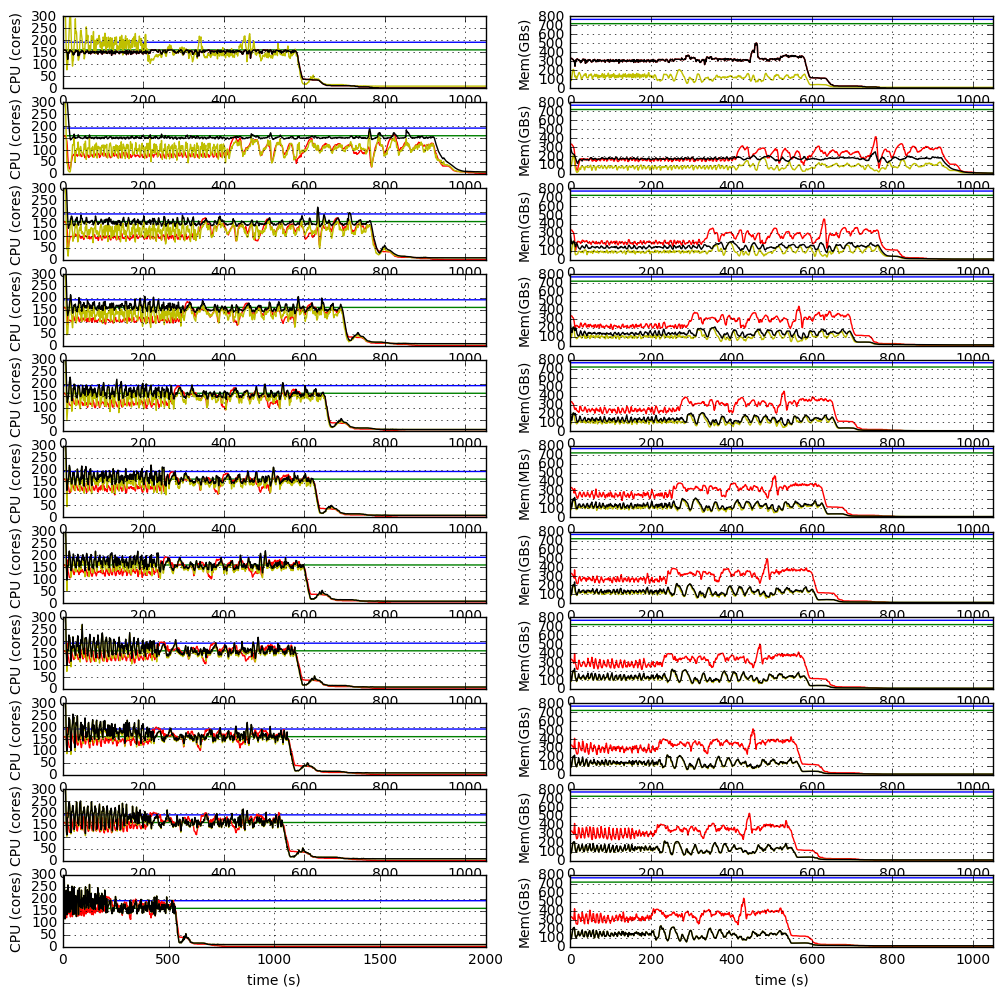

In [1295]:
x = range(len(node_est_cpubtn00_cluster_grp.cpu_cap))
fig = plt.figure(figsize=(12,12))
#ax = fig.add_subplot(211)
#ax.plot(x,cluster_grp.mem_cap,'-b')
#ax.plot(x,cluster_grp.mem_allow,'-g')
#ax.plot(x,cluster_grp.mem_resv,'-r')
#ax.plot(x,cluster_grp.mem_current,'-y')
#ax.fill_between(cluster_grp.mem_resv, 0, cluster_grp.mem_current, facecolor='blue', alpha=0.3)
#ax.axis([0, 1000, 0, 200000])
plotlength = 1050

ax1 = fig.add_subplot(11,2,1)
ax1.plot(x,node_est_cpubtn00_cluster_grp.cpu_cap,'-b')
ax1.plot(x,node_est_cpubtn00_cluster_grp.cpu_allow,'-g')
ax1.plot(x,node_est_cpubtn00_cluster_grp.cpu_resv,'-r')
ax1.plot(x,node_est_cpubtn00_cluster_grp.cpu_current,'-y')
ax1.plot(x,node_est_cpubtn00_cluster_grp.cpu_est,'-k')
ax1.axis([0, plotlength, 0, 300])
ax1.set_ylabel('CPU (cores)')
#ax1.set_xlabel('time (s)')
ax1.grid()

bx1 = fig.add_subplot(11,2,3)
bx1.plot(x,node_est_cpubtn01_cluster_grp.cpu_cap,'-b')
bx1.plot(x,node_est_cpubtn01_cluster_grp.cpu_allow,'-g')
bx1.plot(x,node_est_cpubtn01_cluster_grp.cpu_resv,'-r')
bx1.plot(x,node_est_cpubtn01_cluster_grp.cpu_current,'-y')
bx1.plot(x,node_est_cpubtn01_cluster_grp.cpu_est,'-k')
bx1.axis([0, plotlength, 0, 300])
bx1.set_ylabel('CPU (cores)')
#bx1.set_xlabel('time (s)')
bx1.grid()

cx1 = fig.add_subplot(11,2,5)
cx1.plot(x,node_est_cpubtn02_cluster_grp.cpu_cap,'-b')
cx1.plot(x,node_est_cpubtn02_cluster_grp.cpu_allow,'-g')
cx1.plot(x,node_est_cpubtn02_cluster_grp.cpu_resv,'-r')
cx1.plot(x,node_est_cpubtn02_cluster_grp.cpu_current,'-y')
cx1.plot(x,node_est_cpubtn02_cluster_grp.cpu_est,'-k')
cx1.axis([0, plotlength, 0, 300])
cx1.set_ylabel('CPU (cores)')
#cx1.set_xlabel('time (s)')
cx1.grid()

dx1 = fig.add_subplot(11,2,7)
dx1.plot(x,node_est_cpubtn03_cluster_grp.cpu_cap,'-b')
dx1.plot(x,node_est_cpubtn03_cluster_grp.cpu_allow,'-g')
dx1.plot(x,node_est_cpubtn03_cluster_grp.cpu_resv,'-r')
dx1.plot(x,node_est_cpubtn03_cluster_grp.cpu_current,'-y')
dx1.plot(x,node_est_cpubtn03_cluster_grp.cpu_est,'-k')
dx1.axis([0, plotlength, 0, 300])
dx1.set_ylabel('CPU (cores)')
#dx1.set_xlabel('time (s)')
dx1.grid()

ex1 = fig.add_subplot(11,2,9)
ex1.plot(x,node_est_cpubtn04_cluster_grp.cpu_cap,'-b')
ex1.plot(x,node_est_cpubtn04_cluster_grp.cpu_allow,'-g')
ex1.plot(x,node_est_cpubtn04_cluster_grp.cpu_resv,'-r')
ex1.plot(x,node_est_cpubtn04_cluster_grp.cpu_current,'-y')
ex1.plot(x,node_est_cpubtn04_cluster_grp.cpu_est,'-k')
ex1.axis([0, plotlength, 0, 300])
ex1.set_ylabel('CPU (cores)')
#ex1.set_xlabel('time (s)')
ex1.grid()

fx1 = fig.add_subplot(11,2,11)
fx1.plot(x,node_est_cpubtn05_cluster_grp.cpu_cap,'-b')
fx1.plot(x,node_est_cpubtn05_cluster_grp.cpu_allow,'-g')
fx1.plot(x,node_est_cpubtn05_cluster_grp.cpu_resv,'-r')
fx1.plot(x,node_est_cpubtn05_cluster_grp.cpu_current,'-y')
fx1.plot(x,node_est_cpubtn05_cluster_grp.cpu_est,'-k')
fx1.axis([0, plotlength, 0, 300])
fx1.set_ylabel('CPU (cores)')
#fx1.set_xlabel('time (s)')
fx1.grid()

gx1 = fig.add_subplot(11,2,13)
gx1.plot(x,node_est_cpubtn06_cluster_grp.cpu_cap,'-b')
gx1.plot(x,node_est_cpubtn06_cluster_grp.cpu_allow,'-g')
gx1.plot(x,node_est_cpubtn06_cluster_grp.cpu_resv,'-r')
gx1.plot(x,node_est_cpubtn06_cluster_grp.cpu_current,'-y')
gx1.plot(x,node_est_cpubtn06_cluster_grp.cpu_est,'-k')
gx1.axis([0, plotlength, 0, 300])
gx1.set_ylabel('CPU (cores)')
#gx1.set_xlabel('time (s)')
gx1.grid()

hx1 = fig.add_subplot(11,2,15)
hx1.plot(x,node_est_cpubtn07_cluster_grp.cpu_cap,'-b')
hx1.plot(x,node_est_cpubtn07_cluster_grp.cpu_allow,'-g')
hx1.plot(x,node_est_cpubtn07_cluster_grp.cpu_resv,'-r')
hx1.plot(x,node_est_cpubtn07_cluster_grp.cpu_current,'-y')
hx1.plot(x,node_est_cpubtn07_cluster_grp.cpu_est,'-k')
hx1.axis([0, plotlength, 0, 300])
hx1.set_ylabel('CPU (cores)')
#hx1.set_xlabel('time (s)')
hx1.grid()

jx1 = fig.add_subplot(11,2,17)
jx1.plot(x,node_est_cpubtn08_cluster_grp.cpu_cap,'-b')
jx1.plot(x,node_est_cpubtn08_cluster_grp.cpu_allow,'-g')
jx1.plot(x,node_est_cpubtn08_cluster_grp.cpu_resv,'-r')
jx1.plot(x,node_est_cpubtn08_cluster_grp.cpu_current,'-y')
jx1.plot(x,node_est_cpubtn08_cluster_grp.cpu_est,'-k')
jx1.axis([0, plotlength, 0, 300])
jx1.set_ylabel('CPU (cores)')
#jx1.set_xlabel('time (s)')
jx1.grid()

kx1 = fig.add_subplot(11,2,19)
kx1.plot(x,node_est_cpubtn09_cluster_grp.cpu_cap,'-b')
kx1.plot(x,node_est_cpubtn09_cluster_grp.cpu_allow,'-g')
kx1.plot(x,node_est_cpubtn09_cluster_grp.cpu_resv,'-r')
kx1.plot(x,node_est_cpubtn09_cluster_grp.cpu_current,'-y')
kx1.plot(x,node_est_cpubtn09_cluster_grp.cpu_est,'-k')
kx1.axis([0, plotlength, 0, 300])
kx1.set_ylabel('CPU (cores)')
#kx1.set_xlabel('time (s)')
kx1.grid()

lx1 = fig.add_subplot(11,2,21)
lx1.plot(x,node_est_cpubtn10_cluster_grp.cpu_cap,'-b')
lx1.plot(x,node_est_cpubtn10_cluster_grp.cpu_allow,'-g')
lx1.plot(x,node_est_cpubtn10_cluster_grp.cpu_resv,'-r')
lx1.plot(x,node_est_cpubtn10_cluster_grp.cpu_current,'-y')
lx1.plot(x,node_est_cpubtn10_cluster_grp.cpu_est,'-k')
lx1.axis([0, 2000, 0, 300])
lx1.set_ylabel('CPU (cores)')
lx1.set_xlabel('time (s)')
lx1.grid()

### Plot mem
plotheight = 800

ax2 = fig.add_subplot(11,2,2)
ax2.plot(x,node_est_cpubtn00_cluster_grp.mem_cap,'-b')
ax2.plot(x,node_est_cpubtn00_cluster_grp.mem_allow,'-g')
ax2.plot(x,node_est_cpubtn00_cluster_grp.mem_resv,'-r')
ax2.plot(x,node_est_cpubtn00_cluster_grp.mem_current,'-y')
ax2.plot(x,node_est_cpubtn00_cluster_grp.mem_est,'-k')
ax2.axis([0, plotlength, 0, plotheight])
ax2.set_ylabel('Mem(GBs)')
#ax2.set_xlabel('time (s)')
ax2.grid()

bx2 = fig.add_subplot(11,2,4)
bx2.plot(x,node_est_cpubtn01_cluster_grp.mem_cap,'-b')
bx2.plot(x,node_est_cpubtn01_cluster_grp.mem_allow,'-g')
bx2.plot(x,node_est_cpubtn01_cluster_grp.mem_resv,'-r')
bx2.plot(x,node_est_cpubtn01_cluster_grp.mem_current,'-y')
bx2.plot(x,node_est_cpubtn01_cluster_grp.mem_est,'-k')
bx2.axis([0, plotlength, 0, plotheight])
bx2.set_ylabel('Mem(GBs)')
#bx2.set_xlabel('time (s)')
bx2.grid()

cx2 = fig.add_subplot(11,2,6)
cx2.plot(x,node_est_cpubtn02_cluster_grp.mem_cap,'-b')
cx2.plot(x,node_est_cpubtn02_cluster_grp.mem_allow,'-g')
cx2.plot(x,node_est_cpubtn02_cluster_grp.mem_resv,'-r')
cx2.plot(x,node_est_cpubtn02_cluster_grp.mem_current,'-y')
cx2.plot(x,node_est_cpubtn02_cluster_grp.mem_est,'-k')
cx2.axis([0, plotlength, 0, plotheight])
cx2.set_ylabel('Mem(GBs)')
#cx2.set_xlabel('time (s)')
cx2.grid()

dx2 = fig.add_subplot(11,2,8)
dx2.plot(x,node_est_cpubtn03_cluster_grp.mem_cap,'-b')
dx2.plot(x,node_est_cpubtn03_cluster_grp.mem_allow,'-g')
dx2.plot(x,node_est_cpubtn03_cluster_grp.mem_resv,'-r')
dx2.plot(x,node_est_cpubtn03_cluster_grp.mem_current,'-y')
dx2.plot(x,node_est_cpubtn03_cluster_grp.mem_est,'-k')
dx2.axis([0, plotlength, 0, plotheight])
dx2.set_ylabel('Mem(GBs)')
#dx2.set_xlabel('time (s)')
dx2.grid()

ex2 = fig.add_subplot(11,2,10)
ex2.plot(x,node_est_cpubtn04_cluster_grp.mem_cap,'-b')
ex2.plot(x,node_est_cpubtn04_cluster_grp.mem_allow,'-g')
ex2.plot(x,node_est_cpubtn04_cluster_grp.mem_resv,'-r')
ex2.plot(x,node_est_cpubtn04_cluster_grp.mem_current,'-y')
ex2.plot(x,node_est_cpubtn04_cluster_grp.mem_est,'-k')
ex2.axis([0, plotlength, 0, plotheight])
ex2.set_ylabel('Mem(GBs)')
#ex2.set_xlabel('time (s)')
ex2.grid()

fx2 = fig.add_subplot(11,2,12)
fx2.plot(x,node_est_cpubtn05_cluster_grp.mem_cap,'-b')
fx2.plot(x,node_est_cpubtn05_cluster_grp.mem_allow,'-g')
fx2.plot(x,node_est_cpubtn05_cluster_grp.mem_resv,'-r')
fx2.plot(x,node_est_cpubtn05_cluster_grp.mem_current,'-y')
fx2.plot(x,node_est_cpubtn05_cluster_grp.mem_est,'-k')
fx2.axis([0, plotlength, 0, plotheight])
fx2.set_ylabel('Mem(MBs)')
#fx2.set_xlabel('time (s)')
fx2.grid()

gx2 = fig.add_subplot(11,2,14)
gx2.plot(x,node_est_cpubtn06_cluster_grp.mem_cap,'-b')
gx2.plot(x,node_est_cpubtn06_cluster_grp.mem_allow,'-g')
gx2.plot(x,node_est_cpubtn06_cluster_grp.mem_resv,'-r')
gx2.plot(x,node_est_cpubtn06_cluster_grp.mem_current,'-y')
gx2.plot(x,node_est_cpubtn06_cluster_grp.mem_est,'-k')
gx2.axis([0, plotlength, 0, plotheight])
gx2.set_ylabel('Mem(GBs)')
#gx2.set_xlabel('time (s)')
gx2.grid()

hx2 = fig.add_subplot(11,2,16)
hx2.plot(x,node_est_cpubtn07_cluster_grp.mem_cap,'-b')
hx2.plot(x,node_est_cpubtn07_cluster_grp.mem_allow,'-g')
hx2.plot(x,node_est_cpubtn07_cluster_grp.mem_resv,'-r')
hx2.plot(x,node_est_cpubtn07_cluster_grp.mem_current,'-y')
hx2.plot(x,node_est_cpubtn07_cluster_grp.mem_est,'-k')
hx2.axis([0, plotlength, 0, plotheight])
hx2.set_ylabel('Mem(GBs)')
#hx2.set_xlabel('time (s)')
hx2.grid()

jx2 = fig.add_subplot(11,2,18)
jx2.plot(x,node_est_cpubtn08_cluster_grp.mem_cap,'-b')
jx2.plot(x,node_est_cpubtn08_cluster_grp.mem_allow,'-g')
jx2.plot(x,node_est_cpubtn08_cluster_grp.mem_resv,'-r')
jx2.plot(x,node_est_cpubtn08_cluster_grp.mem_current,'-y')
jx2.plot(x,node_est_cpubtn08_cluster_grp.mem_est,'-k')
jx2.axis([0, plotlength, 0, plotheight])
jx2.set_ylabel('Mem(GBs)')
#jx2.set_xlabel('time (s)')
jx2.grid()

kx2 = fig.add_subplot(11,2,20)
kx2.plot(x,node_est_cpubtn09_cluster_grp.mem_cap,'-b')
kx2.plot(x,node_est_cpubtn09_cluster_grp.mem_allow,'-g')
kx2.plot(x,node_est_cpubtn09_cluster_grp.mem_resv,'-r')
kx2.plot(x,node_est_cpubtn09_cluster_grp.mem_current,'-y')
kx2.plot(x,node_est_cpubtn09_cluster_grp.mem_est,'-k')
kx2.axis([0, plotlength, 0, plotheight])
kx2.set_ylabel('Mem(GBs)')
#kx2.set_xlabel('time (s)')
kx2.grid()

lx2 = fig.add_subplot(11,2,22)
lx2.plot(x,node_est_cpubtn10_cluster_grp.mem_cap,'-b')
lx2.plot(x,node_est_cpubtn10_cluster_grp.mem_allow,'-g')
lx2.plot(x,node_est_cpubtn10_cluster_grp.mem_resv,'-r')
lx2.plot(x,node_est_cpubtn10_cluster_grp.mem_current,'-y')
lx2.plot(x,node_est_cpubtn10_cluster_grp.mem_est,'-k')
lx2.axis([0, plotlength, 0, plotheight])
lx2.set_ylabel('Mem(GBs)')
lx2.set_xlabel('time (s)')
lx2.grid()

ValueError: x and y must have same first dimension

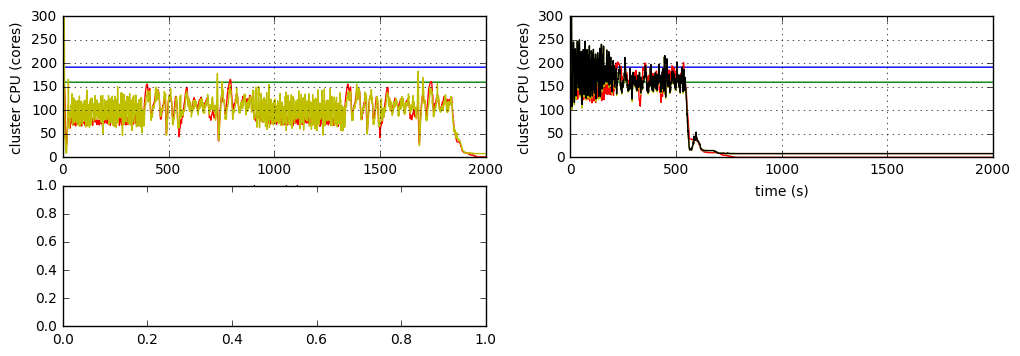

In [1243]:
ax = fig.add_subplot(223)
ax.plot(x,node_est_cluster_simulated_result_svr.cpu_cap,'-b')
ax.plot(x,node_est_cluster_simulated_result_svr.cpu_allow,'-g')
ax.plot(x,node_est_cluster_simulated_result_svr.cpu_resv,'-r')
ax.plot(x,node_est_cluster_simulated_result_svr.cpu_current,'-y')
#ax.plot(node1.CPU_Estimated, '-k')
#ax.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization', 'Estimation'])
#ax.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'])
#ax.legend(['Capacity', 'Allowance', 'Reservation', 'Utilization'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#           ncol=4, mode="expand", borderaxespad=0.)
#ax.set_title('Estimation mode')
ax.set_xlabel('time')
ax.set_ylabel('node CPU (cores)')
ax.grid()
ax.axis([0,5000,0,30])



cx = fig.add_subplot(224)
cx.plot(x,reservation_cluster_simulated_result_svr.cpu_cap,'-b')
cx.plot(x,reservation_cluster_simulated_result_svr.cpu_allow,'-g')
cx.plot(x,reservation_cluster_simulated_result_svr.cpu_resv,'-r')
cx.plot(x,reservation_cluster_simulated_result_svr.cpu_current,'-y')
cx.plot(x,reservation_cluster_simulated_result_svr.cpu_est,'-k')
#cx.set_title('Reservation mode')
cx.legend(['Capacity', 'Allowance', 'User\'s Reservation', 'Utilization'], bbox_to_anchor=(0., 1.05, 2.2, .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.)
cx.set_xlabel('time')
cx.set_ylabel('node CPU (cores)')
cx.grid()
cx.axis([0,5000,0,30])
## To plot figure for seperate node: filter node => plot

In [1057]:
mean = cluster_grp[(cluster_grp.index < 800)].cpu_current.mean()
print(mean)
var = cluster_grp[(cluster_grp.index < 800)].cpu_current.var()
print(var)
std = cluster_grp[(cluster_grp.index < 800)].cpu_current.std()
print(std)

57.8912964125
346.363199983
18.6108355531


In [1059]:
mean = reservation_cluster_grp[(reservation_cluster_grp.index < 800)].cpu_current.mean()
var = reservation_cluster_grp[(reservation_cluster_grp.index < 800)].cpu_current.var()
std = reservation_cluster_grp[(reservation_cluster_grp.index < 800)].cpu_current.std()
print(mean)
print(var)
print(std)

68.5732836403
713.630916371
26.7138712352


In [1060]:
mean = reservation_cluster_simulated_result_svr[(reservation_cluster_simulated_result_svr.index < 800)].cpu_current.mean()
var = reservation_cluster_simulated_result_svr[(reservation_cluster_simulated_result_svr.index < 800)].cpu_current.var()
std = reservation_cluster_simulated_result_svr[(reservation_cluster_simulated_result_svr.index < 800)].cpu_current.std()
print(mean)
print(var)
print(std)

3.33179086867
19.6359602375
4.43124815797


In [1061]:
mean = cluster_simulated_result_svr[(cluster_simulated_result_svr.index < 800)].cpu_current.mean()
var = cluster_simulated_result_svr[(cluster_simulated_result_svr.index < 800)].cpu_current.var()
std = cluster_simulated_result_svr[(cluster_simulated_result_svr.index < 800)].cpu_current.std()
print(mean)
print(var)
print(std)

3.17068194762
13.9571436796
3.73592608059


In [1066]:
cluster_simulated_result_svr.head(n=800).describe()

time  mem_cap  cpu_cap  mem_allow  cpu_allow      mem_resv  \
count  800.0000    800.0    800.0      800.0      800.0    800.000000   
mean   399.5000  16384.0     12.0    14336.0        8.0  10731.520000   
std    231.0844      0.0      0.0        0.0        0.0   2760.755248   
min      0.0000  16384.0     12.0    14336.0        8.0   6144.000000   
25%    199.7500  16384.0     12.0    14336.0        8.0   8192.000000   
50%    399.5000  16384.0     12.0    14336.0        8.0  10240.000000   
75%    599.2500  16384.0     12.0    14336.0        8.0  12288.000000   
max    799.0000  16384.0     12.0    14336.0        8.0  18432.000000   

        cpu_resv   mem_current  cpu_current  
count  800.00000    800.000000   800.000000  
mean     5.08125   5471.571063     7.235005  
std      1.26754   2000.909138     4.199415  
min      3.00000   1374.000000     1.010000  
25%      4.00000   4083.500000     3.946321  
50%      5.00000   5215.733888     6.787054  
75%      6.00000   6710.058798     9.430500  
max      8.00000  11571.199999    22.318000

In [1067]:
reservation_cluster_simulated_result_svr.head(n=800).describe()

time  mem_cap  cpu_cap  mem_allow  cpu_allow  mem_resv    cpu_resv  \
count  800.0000    800.0    800.0      800.0      800.0     800.0  800.000000   
mean   399.5000  16384.0     12.0    14336.0        8.0   14336.0    6.922500   
std    231.0844      0.0      0.0        0.0        0.0       0.0    0.298505   
min      0.0000  16384.0     12.0    14336.0        8.0   14336.0    5.000000   
25%    199.7500  16384.0     12.0    14336.0        8.0   14336.0    7.000000   
50%    399.5000  16384.0     12.0    14336.0        8.0   14336.0    7.000000   
75%    599.2500  16384.0     12.0    14336.0        8.0   14336.0    7.000000   
max    799.0000  16384.0     12.0    14336.0        8.0   14336.0    7.000000   

        mem_current  cpu_current  
count    800.000000   800.000000  
mean    7439.887425     9.184896  
std     2426.055101     4.743727  
min     2027.000000     1.190000  
25%     5639.552101     5.860472  
50%     7778.522725     7.897903  
75%     9274.249999    11.932469  
max    11878.400000    26.539000

In [1068]:
reservation_cluster_grp.head(n=800).describe()

mem_cap  cpu_cap  mem_allow  cpu_allow  mem_resv    cpu_resv  \
count     800.0    800.0      800.0      800.0     800.0  800.000000   
mean   131072.0     96.0   114688.0       64.0  114688.0   55.012500   
std         0.0      0.0        0.0        0.0       0.0    0.973925   
min    131072.0     96.0   114688.0       64.0  114688.0   46.000000   
25%    131072.0     96.0   114688.0       64.0  114688.0   55.000000   
50%    131072.0     96.0   114688.0       64.0  114688.0   55.000000   
75%    131072.0     96.0   114688.0       64.0  114688.0   56.000000   
max    131072.0     96.0   114688.0       64.0  114688.0   56.000000   

        mem_current  cpu_current  
count    800.000000   800.000000  
mean   55379.721572    68.573284  
std    13529.648686    26.713871  
min    23848.346853    21.943248  
25%    46225.278325    47.671381  
50%    58250.474682    61.266222  
75%    66504.876485    92.724246  
max    81710.999973   161.172167

In [1069]:
cluster_grp.head(n=800).describe()

mem_cap  cpu_cap  mem_allow  cpu_allow      mem_resv    cpu_resv  \
count     800.0    800.0      800.0      800.0     800.00000  800.000000   
mean   131072.0     96.0   114688.0       64.0   88312.32000   42.367500   
std         0.0      0.0        0.0        0.0    9073.49156    4.247941   
min    131072.0     96.0   114688.0       64.0   67584.00000   33.000000   
25%    131072.0     96.0   114688.0       64.0   81920.00000   40.000000   
50%    131072.0     96.0   114688.0       64.0   88064.00000   42.000000   
75%    131072.0     96.0   114688.0       64.0   92160.00000   44.000000   
max    131072.0     96.0   114688.0       64.0  141312.00000   69.000000   

        mem_current  cpu_current  
count    800.000000   800.000000  
mean   44810.308874    57.891296  
std     7667.354749    18.610836  
min    21122.200000    17.946000  
25%    39886.914022    44.438328  
50%    45181.425215    56.177661  
75%    49956.368536    69.362927  
max    76275.799988   158.066000